# Assignment Details: 

Build a Logistic Regression Model on Amazon Fine Food Reviews data set. Amazon Fine Food Reviews data set consists of reviews of fine foods from Amazon. <br>

Data source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

#Reviews                   : 568,454 
#Users                     : 256,059 
#Products                  : 74,258 
 Time Span                 : Oct 1999 - Oct 2012
#Attributes/Columns in set : 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2). It is binary classification task. Ignore review rating  = 3.

Note: The baseline model (Naive Bayes with Tf-idf) has achieved 80% AUC, target is to get better auc measure than this with Logistic Regression


In [1]:
# ==================================================== Import Libraries ========================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3 # for importing data from sqlite database
import nltk #for Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer #for bag of words
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer # for term frequency/inverse document frequency of words
 # Model Performance measures
from sklearn.metrics import confusion_matrix , roc_curve, auc, accuracy_score, precision_recall_fscore_support
import re # References for Regular Expressions: https://docs.python.org/3/howto/regex.html, https://regexr.com/2vhbb
import warnings
from nltk.corpus import stopwords
from wordcloud import WordCloud
from gensim.models import Word2Vec
warnings.simplefilter('ignore')
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV # Brute force method
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV # Random search method
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import itertools

C:\Users\vajrapra\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# ====================================================== Importing data ========================================================
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query('Select * from Reviews',conn) 
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,em_words,cleaned_sent,cleaned_sent_w2v
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,,have bought sever the vital can dog food produ...,have bought several the vitality canned dog fo...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,,product arriv label jumbo salt peanut the pean...,product arrived labeled jumbo salted peanuts t...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,,this confect that has been around few centuri ...,this confection that has been around few centu...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,,you are look for the secret ingredi robitussin...,you are looking for the secret ingredient robi...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,,great taffi great price there was wide assort ...,great taffy great price there was wide assortm...


Since, we have time in the data, we can make time based splitting of data into train and test.

In [3]:
# ============================================== Time based Train, Test data split =============================================
df = data.sort_values(by='Time')

train = df[:round(0.7*data.shape[0])]
test = df[round(0.7*data.shape[0]):]
#x_train,x_test,y_train,y_test = train_test_split(tr_tfidfw2v_features,train['label'], random_state = 3, test_size = 0.2)
print(df.shape)
print(train.shape)
print(test.shape)

(328769, 14)
(230138, 14)
(98631, 14)


In [4]:
# ========================================= Feature Engineering: BOW: Bag of Words =============================================
count_vec = CountVectorizer(stop_words='english')
bow_words = count_vec.fit_transform(train['cleaned_sent'].values)
bow_words.shape

(230138, 57250)

In [5]:
np.isnan(bow_words.data).any()

False

In [6]:
# ================================ Feature Engineering: TF-IDF: Term Frequency-Inverse Document Frequency ======================
tfidf_vec = TfidfVectorizer(stop_words = 'english',ngram_range=(1,2), max_df= 500, min_df = 2)
tfidf_words = tfidf_vec.fit_transform(train['cleaned_sent'])
tfidf_words.shape

(230138, 723876)

In [7]:
# ================================== Building Word2Vec model with train data ===================================================
list_of_sent = [text.split() for text in train['cleaned_sent_w2v']]
w2v_model = Word2Vec(list_of_sent)

In [8]:
w2v_model.wv['great']

array([-1.036667  , -2.5182836 ,  2.785881  ,  0.656313  , -2.4099596 ,
       -0.484079  ,  1.3483852 , -1.7720402 , -1.8029656 , -0.197735  ,
        0.12028257,  2.100974  ,  2.5054097 ,  0.10525219, -0.18863672,
        3.4138312 , -2.923981  ,  1.6495534 , -1.2935141 , -2.3114066 ,
       -1.7427557 ,  0.9916308 ,  1.499624  , -0.17253001,  1.1702985 ,
       -1.1508133 ,  1.970812  , -1.5204527 , -1.3454422 , -1.0851955 ,
        0.31215256,  0.6877148 , -0.12481632, -0.08273152,  2.127125  ,
        1.4736346 , -2.0434887 ,  0.52547944, -0.11132603, -1.1499755 ,
        1.6253825 ,  1.413287  ,  1.503809  ,  0.5036869 , -0.12178563,
        2.9819615 , -1.3569965 ,  1.3920302 , -1.538925  ,  0.6002959 ,
        1.816583  ,  0.4363224 ,  2.421355  ,  1.7683246 , -0.29835778,
       -1.8673577 ,  2.9609096 ,  0.9448266 ,  0.05329424,  4.7416177 ,
        1.9253638 , -0.18328573, -0.20786878, -1.999239  ,  0.3237871 ,
        1.1848007 , -3.297491  ,  0.38038966, -1.9008001 , -0.16

In [9]:
# ================================= Feature Engineering: Avg W2V - Average Word2Vec based features =============================
sent_vectors = []
count = 0
for text in tqdm(df['cleaned_sent_w2v'].values):
    counter = 0
    sent_vec = np.zeros(100)
    for word in text.split():
        try:
            word_vec = w2v_model.wv[word]
            sent_vec += word_vec
            counter +=1
        except:
            count +=1
            pass
    sent_vec /= counter
    sent_vectors.append(sent_vec)
print('#of words not present in word2vec model built on train set is:', count)

100%|████████████████████████████████| 328769/328769 [01:05<00:00, 5048.43it/s]


#of words not present in word2vec model built on train set is: 134445


In [10]:
sent_vect = np.array(sent_vectors)
sent_vect = np.where(np.isnan(sent_vect), 0, sent_vect)

In [11]:
# ============== Feature Engineering: TF-IDF W2V - Weighed average of word2vec based on tf-idf (weight) of the word ============

tfidfvec = TfidfVectorizer()
# give a matrix of all words, each cell represented by word, sentence has the tf-idf value
tfidfwords = tfidfvec.fit_transform(train['cleaned_sent_w2v']) 
dictionary = dict(zip(tfidfvec.get_feature_names(),list(tfidfvec.idf_)))

list_of_sent = []
for sent in df['cleaned_sent_w2v'].values:
    list_of_sent.append(sent.split())
    
i = 0 # text row_id
tfidf_sent_vectors = []
for text in tqdm(list_of_sent):
    counter = 0
    sent_vec = np.zeros(100)
    tfidf_sent =0
    for word in text:
        try:
            word_vec = w2v_model.wv[word]
            # tfidf_word = tfidfwords[i,tfidfwords_features.index(word)]
            tfidf_word = dictionary[word]*text.count(word)/len(text)
            sent_vec += word_vec*tfidf_word
            tfidf_sent += tfidf_word
        except:
            pass
    sent_vec /= tfidf_sent 
    tfidf_sent_vectors.append(sent_vec)
    i+=1

100%|████████████████████████████████| 328769/328769 [02:35<00:00, 2107.80it/s]


In [52]:
tfidf_sent_vect = np.array(tfidf_sent_vectors)
tfidf_sent_vect = np.where(np.isnan(tfidf_sent_vect), 0, tfidf_sent_vect)

In [13]:
# Check for balance of classes
print(sum(df['Score']=='Positive')/df.shape[0])

0.8387439205034538


In [14]:
# UDF for Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    
    title = 'Confusion matrix, without normalization'
    plt.figure(figsize=(20, 4))
    plt.subplot(1,2,1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
     
    title = "Normalized confusion matrix"
    plt.subplot(1,2,2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()   
    
def print_top10(vectorizer, clf, n):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))   

The dataset seems to be highly biased (4 times) towards Positive reviews, and hence is an imbalanced dataset. Data needs to be
balanced to train a model. Or we can penalise the mis-classification error on Negative review 4 times than misclassification error on Positive review to make model learning unbiased.

Logistic Regression Model: It is a supervised, probability based model with an assumption that all features are linearly independent of each other and the classes are almost linearly separable. It finds a hyperplane that separates the classes with minimal classification errors and maximal signed distance. To ensure that coefficients don't inflate, model has decent accuracy and since, we have high dimensional data, we use hyper-tuning paramater to penalise the coefficients of features with less importance. Higher the value of tuning parameter, higher the bias, underfitting is the model and viceversa. This can be achieved using Cross-Validation technique with different values of tuning parameters. And, pick the best of all.

And since this is a time based cross validation, the constraint on Validation set is to be always future in nature, with reference to the training subset of the model. So, in a K-fold time based validation, in kth split, first k folds are taken as train data and (k+1)th data set is taken as validation data. Essentially, every successive training sets are supersets of those that come before them.

Note: Read 'Test' as Validation set of the data.

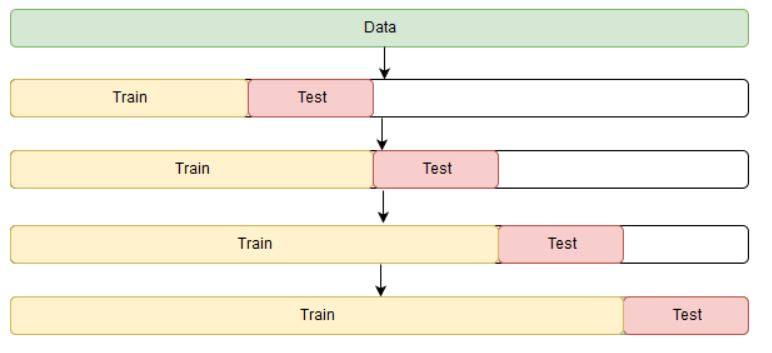



Best tuning parameter search can be done in a brute force manner where we supply a list of tuning parameters to the model.
It is Grid Search cross validation method. It can also be tuned using random search cross validation where it randomly picks few values within the range of the input values sent while building the model. It is Random Seach cross validation method.

Regularization/Penalization of weights of the hyperplane/logistic regression model can be done using L1 or L2 Regularization. 
L1 Regularization gives sparsity to the model while L2 regularization retains all the features. More the regularization weight, higher the penalty on variable weights, hence, results in higher bias (Underfitted model). L1 Regularization is preferred over L2 regularization when we have high dimensional dataset or the variables have a very high corelation among them. If there is minimal corelation between the variables, L2 is preferred over L1 to make sure model doesn't lose any information due to sparsity. 

Since, Logistic regression is a distance based model, it is better to standardise the features. Standardization of feature ensures all features have mean = 0 and standard deviation = 1. Since, the bag of words & term frequency features are sparse matrices, standardization of features has to be done without changing the mean, else the sparse matrix becomes a dense matrix.

###  ======================= Bag of Words Logistic Regression Model ================================

## Logistic Regression Model with Bag of Words features,Gridsearch CV & L1 regularization

In [14]:
# ========================================== Model with Bag of Words features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l1'],'alpha': [10 ** x for x in range(-4, 5)]}
gs_l1_bow_model = GridSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,scoring ='f1',cv = tscv)

gs_l1_bow_model.fit(X,Y)

print(gs_l1_bow_model.best_estimator_)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [15]:
tscv_scores = gs_l1_bow_model.cv_results_.get('mean_test_score')
trcv_scores = gs_l1_bow_model.cv_results_.get('mean_train_score')

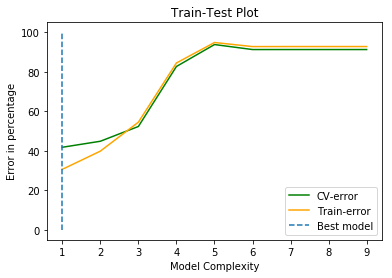

In [16]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(1,9),[0,3,5,8,10,12,16,17,100] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 0.0001. So, picking up the model with alpha = 0.0001.

Let us see if there is any multicolinearity in the model. This can be verified by checking variance/ standard deviation of each coefficients that we get by building models with (alpha =0.0001) random selection of data points from training data.

In [17]:
# =========================================== Multicollinearity Test ===========================================================
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 0.0001, penalty = 'l1')
keys = count_vec.get_feature_names()
coeff = []
for i in list(range(0,10)):
    tr_x,x_test,tr_y,y_test = train_test_split(X,Y,test_size = 0.2, random_state = None)
    model = classifier_name.fit(tr_x,tr_y)
    coeff.append(model.coef_[0])
coeff_df = pd.DataFrame(coeff,columns = count_vec.get_feature_names())
coeff_df

,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaa,aaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaargh,...,zypan,zyrtec,zyto,zziga,zzz,zzzzz,zzzzzzz,zzzzzzzz,zzzzzzzzzz,zzzzzzzzzzz
0,-3.133997,0.000000,52.447483,-12.357811,0.000,0.000000,-20.965050,0.000000,0.0,0.0,...,-89.835536,-18.643751,0.000000,0.0,-12.780359,0.000000,0.0,-58.695138,0.000000,0.000000
1,0.000000,0.000000,-34.988661,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-24.102414
2,-11.570356,0.000000,98.530504,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,-26.214377,0.0,0.000000,0.000000,-57.112892
3,-32.991880,-92.221125,32.507500,-47.401358,0.000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,-51.174898,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-24.423814
4,-62.364898,0.000000,53.007190,0.000000,0.000,-75.357675,-8.669459,0.000000,0.0,0.0,...,-119.750574,0.000000,0.000000,0.0,-12.531607,-34.556165,0.0,-34.967878,-76.709035,0.000000
5,-6.747385,-8.898729,215.079555,-34.211084,0.000,0.000000,0.000000,0.000000,0.0,0.0,...,-29.657477,0.000000,0.000000,0.0,-18.191743,0.000000,0.0,-56.110740,0.000000,-13.050571
6,-47.476711,-35.339126,-8.104246,0.000000,0.000,0.000000,0.000000,-22.567787,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,-27.466526,0.000000,0.0,0.000000,0.000000,0.000000
7,-48.246857,-227.410685,69.261074,-56.034158,0.000,0.000000,0.000000,0.000000,0.0,0.0,...,-12.029180,0.000000,0.000000,0.0,0.000000,-12.447288,0.0,-40.163910,0.000000,-9.204775
8,-112.814834,-239.970387,97.422866,0.000000,-25.841,0.000000,0.000000,0.000000,0.0,0.0,...,-44.192255,-61.078980,0.000000,0.0,-9.998939,-63.773108,0.0,-28.284617,0.000000,0.000000
9,-44.877982,-25.110874,18.706004,-7.999770,0.000,0.000000,0.000000,0.000000,0.0,0.0,...,-36.962233,0.000000,-73.618583,0.0,-62.808656,-12.788931,0.0,0.000000,0.000000,0.000000


In [19]:
print(coeff_df.std(axis=0).sort_values(ascending=False))

frapachino         5833.980652
deciet             5833.980652
llm                4899.469900
muffiin            4793.993072
movabl             4784.781437
mjr                4784.781437
vox                4665.602914
suppo              4651.657534
brusher            4632.226658
puce               4613.310626
colyt              4613.310626
mochachino         4607.170629
styrophoam         4594.644236
changemak          4546.557514
orgigin            4393.994334
grainey            4330.507947
pocuch             4240.492731
quarntiti          4240.492731
esxtrem            4165.615276
mynaturalmarket    4152.295085
dvms               4144.150892
barbitur           4144.150892
lebel              4134.298114
buttjuic           4082.513150
christmasi         4008.507516
photoperiod        3995.393951
underpow           3995.393951
sometyp            3775.123538
deslov             3751.081449
subsctrib          3711.427475
                      ...     
frier                 0.000000
frieda  

#### Observation:
   1. It is evident from above that model has high multicolinearity. Multicolinearity does affect the interpretability of the   features but doesnt affect the performance of the model. And since this is a sentiment analysis on text data, we aren't much bothered about the feature interpretation. 

In [81]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(bow_words)
bow_words_tst1 = count_vec.transform(test['cleaned_sent'].values)
bow_words_tst = X_scaler.transform(bow_words_tst1)
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 0.0001, penalty = 'l1')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_l1_bow = classifier_name.fit(train_X,train_y)
predtest_y_gs_l1_bow = model_gs_l1_bow.predict(bow_words_tst)

# Accuracy score
gs_l1_acc_bow = accuracy_score(test_y, predtest_y_gs_l1_bow, normalize=True)*100
print("Test Accuracy for Logistic Regression model with bag of words:",gs_l1_acc_bow,'%')
# Precision-Recall, f-score
gs_l1_bow_pre, gs_l1_bow_recall, gs_l1_bow_fscore, gs_l1_bow_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_l1_bow,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with bag of words for Negative label reviews:",gs_l1_bow_pre)
print("Test Recall for Logistic Regression model with bag of words for Negative label reviews:",gs_l1_bow_recall)
print("Test fscore for Logistic Regression model with bag of words for Negative label reviews:",gs_l1_bow_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_l1_bow, pos_label = 1)
gs_l1_bow_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with bag of words:",gs_l1_bow_auc_score)
# Confusion matrix
gs_l1_bow_cm = confusion_matrix(test_y, predtest_y_gs_l1_bow)

Test Accuracy for Logistic Regression model with bag of words: 84.28992912978678 %
Test Precision for Logistic Regression model with bag of words for Negative label reviews: 0.5459099804305284
Test Recall for Logistic Regression model with bag of words for Negative label reviews: 0.7817947424471723
Test fscore for Logistic Regression model with bag of words for Negative label reviews: 0.642898296881842
Test AUC for Logistic Regression model with bag of words: 0.819093930203658


In [22]:
(model_gs_l1_bow.coef_==0).sum()/(model_gs_l1_bow.coef_).size

0.4903580786026201

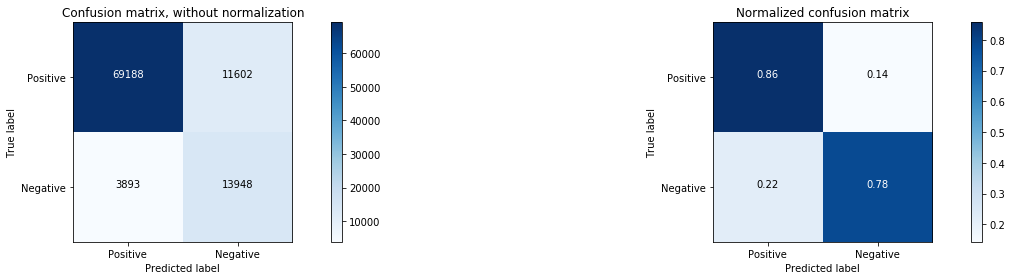

In [21]:
plot_confusion_matrix(gs_l1_bow_cm, ['Positive','Negative'])

#### Observation:
  1. Around 49% of the coefficients are Zero due to L1 regularization.
  2. Best AUC that we have achieved is 82% which is better than the baseline Naive Bayes Model.
  3. 78% of negative reviews are captured with a precision of 55%

In [26]:
# ========================================== Most Important features ===========================================================
print_top10(count_vec, model_gs_l1_bow, n=10)

	-2747.4270	sasanishiki    		13203.1177	beaney         
	-2564.6535	monment        		10704.4923	jermiah        
	-2539.3311	oquendo        		9603.2868	feedingtim     
	-2417.1311	expenspens     		9603.2868	airbubbl       
	-2327.3224	aaaaahhhhhhhhhhhhhhhh		8845.1983	grocceri       
	-2327.3224	putney         		7742.9879	jeweleri       
	-2270.4525	rowland        		7735.3170	maltodwxtrin   
	-2126.7114	definatl       		7059.4457	kadota         
	-2126.7114	eggland        		6848.5990	olestra        
	-2059.7603	eramo          		6772.1427	aisia          


## Logistic Regression Model with Bag of Words features,Gridsearch CV & L2 regularization

In [62]:
# ========================================== Model with Bag of Words features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l2'],'alpha': [10 ** x for x in range(-4, 5)]}
gs_l2_bow_model = GridSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,scoring ='f1',cv = tscv)

gs_l2_bow_model.fit(X,Y)

print(gs_l2_bow_model.best_estimator_)

SGDClassifier(alpha=1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [63]:
tscv_scores = gs_l2_bow_model.cv_results_.get('mean_test_score')
trcv_scores = gs_l2_bow_model.cv_results_.get('mean_train_score')

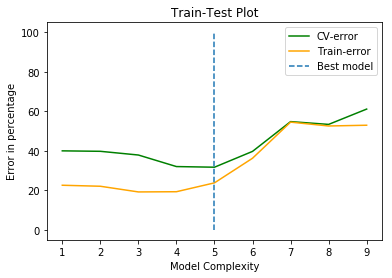

In [65]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(5,9),[0,3,5,8,10,12,16,17,100] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

 Low Cross Validation error and low training error is observed at alpha = 1. So, picking up the model with alpha = 1.

Let us see if there is any multicolinearity in the model. This can be verified by checking variance/ standard deviation of each coefficients that we get by building models with (alpha =1) random selection of data points from training data.

In [70]:
# =========================================== Multicollinearity Test ===========================================================
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 1, penalty = 'l2')
keys = count_vec.get_feature_names()
coeff = []
for i in list(range(0,10)):
    tr_x,x_test,tr_y,y_test = train_test_split(X,Y,test_size = 0.2, random_state = None)
    model = classifier_name.fit(tr_x,tr_y)
    coeff.append(model.coef_[0])
coeff_df = pd.DataFrame(coeff,columns = count_vec.get_feature_names())
coeff_df

,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaa,aaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaargh,...,zypan,zyrtec,zyto,zziga,zzz,zzzzz,zzzzzzz,zzzzzzzz,zzzzzzzzzz,zzzzzzzzzzz
0,-0.000907,-0.001249,0.001374,-0.000695,-0.000567,-0.000509,-0.000513,0.000000,0.000000,-0.000340,...,0.000000,-0.000517,0.000000,-0.000408,-0.000648,-0.000822,0.001467,-0.000627,-0.000404,0.000000
1,-0.000926,-0.001235,0.000884,-0.000700,-0.000573,-0.000488,-0.000550,-0.000465,0.000000,-0.000345,...,-0.000530,-0.000557,-0.000575,-0.000338,-0.000727,-0.000757,0.001507,-0.000700,-0.000393,0.000000
2,-0.001028,-0.001177,0.000422,-0.000697,-0.000578,-0.000495,-0.000523,-0.000468,-0.000532,0.000000,...,0.000000,-0.000712,-0.000583,0.000000,-0.000450,-0.000786,0.001846,-0.000661,-0.000381,-0.000641
3,-0.000953,-0.001186,0.000709,-0.000707,-0.000611,-0.000505,-0.000520,0.000000,-0.000527,0.000000,...,-0.000608,-0.000159,-0.000586,-0.000333,-0.000824,-0.000436,0.001859,-0.000628,0.000000,-0.000645
4,-0.000973,-0.001376,0.000695,-0.000515,0.000000,-0.000506,-0.000529,-0.000447,-0.000519,0.000000,...,-0.000572,-0.000599,0.000000,0.000000,-0.000792,-0.000807,-0.000280,0.000000,-0.000389,-0.000724
5,-0.000960,-0.001201,0.000380,-0.000698,0.000000,-0.000502,-0.000521,0.000000,-0.000533,-0.000320,...,-0.000519,-0.000571,-0.000584,0.000000,-0.000604,-0.000838,0.001784,-0.000607,0.000000,0.000000
6,-0.000979,-0.001237,0.000742,-0.000693,-0.000572,-0.000558,-0.000509,0.000000,-0.000535,-0.000330,...,-0.000568,-0.000507,-0.000580,-0.000294,-0.000799,-0.000471,0.001494,0.000000,0.000000,-0.000557
7,-0.000979,-0.001194,0.000912,0.000000,0.000000,-0.000495,0.000000,-0.000454,-0.000525,0.000000,...,-0.000571,-0.000370,-0.000566,-0.000339,-0.000648,-0.000852,0.001604,-0.000755,-0.000378,-0.000637
8,-0.000961,-0.000946,0.000562,-0.000522,-0.000579,-0.000503,-0.000545,-0.000449,0.000000,-0.000383,...,-0.000555,-0.000509,-0.000579,0.000000,-0.000684,-0.000829,0.001476,-0.000623,-0.000394,-0.000643
9,-0.000402,-0.001081,0.000321,-0.000706,-0.000556,-0.000501,-0.000498,-0.000456,-0.000512,-0.000344,...,0.000000,-0.000775,0.000000,-0.000346,-0.000598,-0.000835,0.001511,-0.000720,-0.000395,-0.000639


In [71]:
print(coeff_df.std(axis=0).sort_values(ascending=False))

jivalim            2.003173e-03
hapkido            1.858581e-03
mozzerela          1.850430e-03
rhodesdian         1.728889e-03
patchwork          1.708191e-03
spenda             1.695913e-03
mor                1.679744e-03
nutrisoda          1.665915e-03
vagan              1.659415e-03
airpocket          1.597620e-03
thenutrocompani    1.584797e-03
antarct            1.578146e-03
distrust           1.571265e-03
btls               1.562336e-03
sonewher           1.549945e-03
hadni              1.513479e-03
drakar             1.511476e-03
dietmind           1.505712e-03
yadayadayada       1.499927e-03
liva               1.490037e-03
petperk            1.485539e-03
compressa          1.477723e-03
cranapl            1.477644e-03
enumer             1.474586e-03
glut               1.471900e-03
diahorrea          1.464303e-03
cocca              1.462599e-03
fyou               1.453367e-03
kneed              1.440547e-03
soooooooooooooo    1.431487e-03
                       ...     
atlanti 

#### Observation:
   1. It is evident from above that model has low multicolinearity.

In [82]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(bow_words)
bow_words_tst1 = count_vec.transform(test['cleaned_sent'].values)
bow_words_tst = X_scaler.transform(bow_words_tst1)
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 1, penalty = 'l2')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_l2_bow = classifier_name.fit(train_X,train_y)
predtest_y_gs_l2_bow = model_gs_l2_bow.predict(bow_words_tst)

# Accuracy score
gs_l2_acc_bow = accuracy_score(test_y, predtest_y_gs_l2_bow, normalize=True)*100
print("Test Accuracy for Logistic Regression model with bag of words:",gs_l2_acc_bow,'%')
# Precision-Recall, f-score
gs_l2_bow_pre, gs_l2_bow_recall, gs_l2_bow_fscore, gs_l2_bow_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_l2_bow,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with bag of words for Negative label reviews:",gs_l2_bow_pre)
print("Test Recall for Logistic Regression model with bag of words for Negative label reviews:",gs_l2_bow_recall)
print("Test fscore for Logistic Regression model with bag of words for Negative label reviews:",gs_l2_bow_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_l2_bow, pos_label = 1)
gs_l2_bow_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with bag of words:",gs_l2_bow_auc_score)
# Confusion matrix
gs_l2_bow_cm = confusion_matrix(test_y, predtest_y_gs_l2_bow)

Test Accuracy for Logistic Regression model with bag of words: 87.77869026979347 %
Test Precision for Logistic Regression model with bag of words for Negative label reviews: 0.6182806687650738
Test Recall for Logistic Regression model with bag of words for Negative label reviews: 0.8477663808082506
Test fscore for Logistic Regression model with bag of words for Negative label reviews: 0.7150624054462934
Test AUC for Logistic Regression model with bag of words: 0.8660913844875514


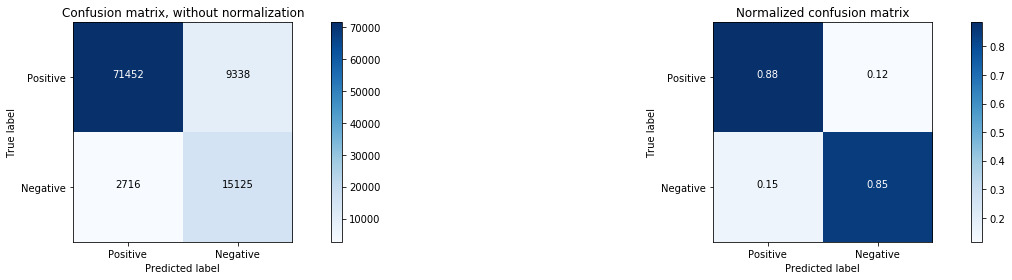

In [24]:
plot_confusion_matrix(gs_l2_bow_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 87% which is better than the baseline Naive Bayes Model.
  2. 85% of negative reviews are captured with a precision of 62%, better than the model with L1 regularization
  3. Of the above 2 models, Bag of Words with L2 regularization seems to be good.

In [25]:
# ========================================== Most Important features ===========================================================
print_top10(count_vec, model_gs_l2_bow, n=10)

	-0.0668	great          		0.0649	disappoint     
	-0.0559	love           		0.0408	worst          
	-0.0470	best           		0.0382	return         
	-0.0398	delici         		0.0371	aw             
	-0.0350	perfect        		0.0370	money          
	-0.0318	good           		0.0369	wast           
	-0.0308	favorit        		0.0367	bad            
	-0.0306	excel          		0.0359	terribl        
	-0.0283	easi           		0.0358	horribl        
	-0.0271	nice           		0.0318	threw          


### Logistic Regression Model with Bag of Words features,Random Search CV & L1 regularization

In [87]:
# ========================================== Model with Bag of Words features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l1'],'alpha': np.random.uniform(10**-2,10**2,10)}
rs_l1_bow_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions =  param,scoring ='f1',cv = tscv)

rs_l1_bow_model.fit(X,Y)
print(rs_l1_bow_model.best_estimator_)

SGDClassifier(alpha=1.3850556226535375, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l1', power_t=0.5, random_state=100,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [116]:
tscv_scores = rs_l1_bow_model.cv_results_.get('mean_test_score')
trcv_scores = rs_l1_bow_model.cv_results_.get('mean_train_score')

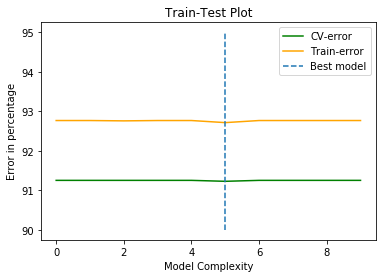

In [93]:
# Bias-Variance plot
x = [0,1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(5,9),[90,91,92,93,93.5,94,94.6,94.7,95] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 1.3850556226535375. So, picking up the model with alpha = 1.3850556226535375

Let us see if there is any multicolinearity in the model. This can be verified by checking variance/ standard deviation of each coefficients that we get by building models with (alpha = 1.3850556226535375) random selection of data points from training data.

In [94]:
# =========================================== Multicollinearity Test ===========================================================
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 1.3850556226535375\
                                , penalty = 'l1')
keys = count_vec.get_feature_names()
coeff = []
for i in list(range(0,10)):
    tr_x,x_test,tr_y,y_test = train_test_split(X,Y,test_size = 0.2, random_state = None)
    model = classifier_name.fit(tr_x,tr_y)
    coeff.append(model.coef_[0])
coeff_df = pd.DataFrame(coeff,columns = count_vec.get_feature_names())
coeff_df

,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaa,aaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaargh,...,zypan,zyrtec,zyto,zziga,zzz,zzzzz,zzzzzzz,zzzzzzzz,zzzzzzzzzz,zzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
print(coeff_df.std(axis=0).sort_values(ascending=False))

kudzu          42.905859
newleyw        42.648624
recipl         36.692913
sotanghon      36.690264
bisquik        33.102587
monogram       28.800454
faili          24.481699
oringin        18.968839
wiht           13.814513
stifn          13.453203
abstract       12.056864
fathom          9.465475
starv           8.958534
mongolian       8.021550
sugarin         6.986790
cheper          5.813395
appetis         5.246383
cartilag        4.564077
foreplay        3.534621
spiciest        3.288556
filipino        3.288202
gnc             3.005678
tlc             2.870971
cooln           2.136487
muggin          2.100289
wingman         2.080590
cirriculum      2.080590
flacid          1.916764
wholewheat      1.797327
awok            1.699584
                 ...    
pismo           0.000000
pisco           0.000000
pitfal          0.000000
pitfb           0.000000
pith            0.000000
pithi           0.000000
pix             0.000000
pivot           0.000000
piut            0.000000


In [83]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(bow_words)
bow_words_tst1 = count_vec.transform(test['cleaned_sent'].values)
bow_words_tst = X_scaler.transform(bow_words_tst1)
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 1.3850556226535375\
                                , penalty = 'l1')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_l1_bow = classifier_name.fit(train_X,train_y)
predtest_y_rs_l1_bow = model_rs_l1_bow.predict(bow_words_tst)

# Accuracy score
rs_l1_acc_bow = accuracy_score(test_y, predtest_y_rs_l1_bow, normalize=True)*100
print("Test Accuracy for Logistic Regression model with bag of words:",rs_l1_acc_bow,'%')
# Precision-Recall, f-score
rs_l1_bow_pre, rs_l1_bow_recall, rs_l1_bow_fscore, rs_l1_bow_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_l1_bow,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with bag of words for Negative label reviews:",rs_l1_bow_pre)
print("Test Recall for Logistic Regression model with bag of words for Negative label reviews:",rs_l1_bow_recall)
print("Test fscore for Logistic Regression model with bag of words for Negative label reviews:",rs_l1_bow_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_l1_bow, pos_label = 1)
rs_l1_bow_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with bag of words:",rs_l1_bow_auc_score)
# Confusion matrix
rs_l1_bow_cm = confusion_matrix(test_y, predtest_y_rs_l1_bow)

Test Accuracy for Logistic Regression model with bag of words: 81.91035272885807 %
Test Precision for Logistic Regression model with bag of words for Negative label reviews: 0.0
Test Recall for Logistic Regression model with bag of words for Negative label reviews: 0.0
Test fscore for Logistic Regression model with bag of words for Negative label reviews: 0.0
Test AUC for Logistic Regression model with bag of words: 0.49999381111523705


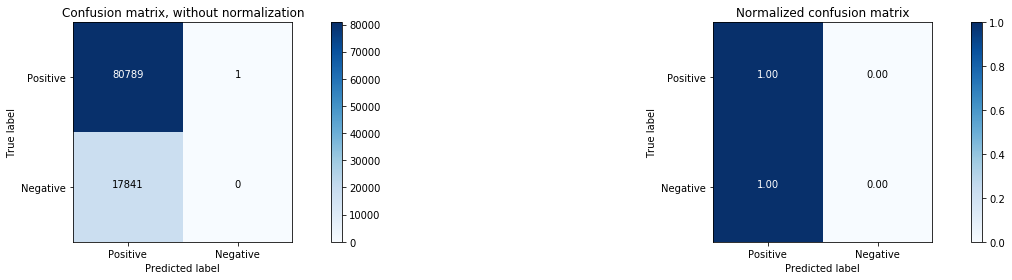

In [31]:
plot_confusion_matrix(rs_l1_bow_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 50% which is worse than the baseline Naive Bayes Model, that means the model is a constant model, predicts all as Positive review.
  2. 0% of negative reviews are captured with a precision of 0%, worse than the model with L2 regularization
  3. Of the above models, Bag of Words with L2 regularization (grid search) seems to be good.

In [32]:
# ========================================== Most Important features ===========================================================
print_top10(count_vec, model_rs_l1_bow, n=10)

	-42.3905	nexco          		7.6536	discolr        
	0.0000	aaa            		5.8537	grocceri       
	0.0000	aaaa           		1.4821	maximus        
	0.0000	aaaaa          		0.0000	zzzzzzzzzzz    
	0.0000	aaaaaa         		0.0000	zzzzzzzzzz     
	0.0000	aaaaaaaaaaa    		0.0000	zzzzzzzz       
	0.0000	aaaaaaaaaaaa   		0.0000	zzzzzzz        
	0.0000	aaaaaaaaaaaaa  		0.0000	zzzzz          
	0.0000	aaaaaaaaaaaaaaa		0.0000	zzz            
	0.0000	aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa		0.0000	zziga          


### Logistic Regression Model with Bag of Words features,Random Search CV & L2 regularization

In [100]:
# ========================================== Model with Bag of Words features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l2'],'alpha': np.random.uniform(10**-2,10**2,10)}
rs_l2_bow_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions =  param,scoring ='f1',cv = tscv)

rs_l2_bow_model.fit(X,Y)
print(rs_l2_bow_model.best_estimator_)

SGDClassifier(alpha=2.534216244823913, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [101]:
tscv_scores = rs_l2_bow_model.cv_results_.get('mean_test_score')
trcv_scores = rs_l2_bow_model.cv_results_.get('mean_train_score')

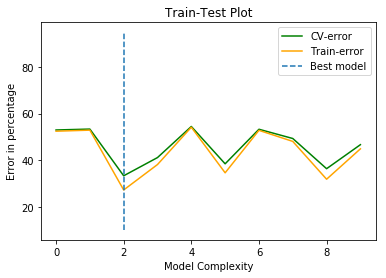

In [103]:
# Bias-Variance plot
x = [0,1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(2,9),[10,21,32,43,53.5,64,74.6,84.7,95] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 2.534216244823913. So, picking up the model with alpha = 2.534216244823913

Let us see if there is any multicolinearity in the model. This can be verified by checking variance/ standard deviation of each coefficients that we get by building models with (alpha = 2.534216244823913) random selection of data points from training data.

In [105]:
# =========================================== Multicollinearity Test ===========================================================
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 2.534216244823913\
                                , penalty = 'l2')
keys = count_vec.get_feature_names()
coeff = []
for i in list(range(0,10)):
    tr_x,x_test,tr_y,y_test = train_test_split(X,Y,test_size = 0.2, random_state = None)
    model = classifier_name.fit(tr_x,tr_y)
    coeff.append(model.coef_[0])
coeff_df = pd.DataFrame(coeff,columns = count_vec.get_feature_names())
coeff_df

,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaa,aaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaargh,...,zypan,zyrtec,zyto,zziga,zzz,zzzzz,zzzzzzz,zzzzzzzz,zzzzzzzzzz,zzzzzzzzzzz
0,-0.000198,-0.000604,-0.000502,-0.000337,-0.000267,-0.000248,-0.000250,-0.000232,-0.000259,-0.000211,...,-0.000271,-0.000422,-0.000262,-0.000206,-0.000351,-0.000384,0.000765,0.000000,-0.000220,-0.000246
1,-0.000426,-0.000622,0.000277,-0.000339,-0.000264,-0.000249,-0.000255,-0.000234,-0.000257,-0.000208,...,-0.000279,-0.000324,0.000000,-0.000207,-0.000346,-0.000362,0.000768,-0.000339,-0.000220,-0.000283
2,-0.000510,-0.000463,0.000360,-0.000340,-0.000268,-0.000254,-0.000264,0.000000,-0.000260,-0.000210,...,-0.000277,-0.000291,0.000000,-0.000203,-0.000321,-0.000383,0.000782,-0.000343,-0.000224,0.000000
3,-0.000489,-0.000512,0.000178,-0.000210,0.000000,-0.000245,-0.000254,-0.000232,-0.000257,-0.000210,...,-0.000274,-0.000361,-0.000260,-0.000214,-0.000455,-0.000200,0.000937,-0.000277,-0.000221,-0.000275
4,-0.000515,-0.000612,0.000243,-0.000212,-0.000266,-0.000244,-0.000252,-0.000234,-0.000257,0.000000,...,-0.000291,-0.000416,-0.000263,-0.000207,-0.000443,-0.000199,0.000786,-0.000343,-0.000221,-0.000279
5,-0.000440,-0.000619,-0.000522,-0.000211,-0.000267,-0.000250,0.000000,-0.000234,-0.000258,-0.000211,...,0.000000,-0.000421,-0.000262,-0.000202,-0.000358,-0.000198,0.000939,-0.000329,-0.000214,-0.000262
6,-0.000433,-0.000631,0.000241,-0.000339,0.000000,-0.000252,-0.000255,-0.000236,0.000000,0.000000,...,0.000000,-0.000195,-0.000262,-0.000202,-0.000352,-0.000383,0.000796,-0.000333,-0.000217,-0.000282
7,-0.000437,-0.000628,0.000289,-0.000340,-0.000266,-0.000246,-0.000256,-0.000234,-0.000257,-0.000207,...,0.000000,-0.000340,0.000000,-0.000197,-0.000256,-0.000371,0.000923,-0.000340,-0.000218,-0.000270
8,-0.000438,-0.000552,0.000132,-0.000339,-0.000266,-0.000248,-0.000223,-0.000231,-0.000258,0.000000,...,0.000000,-0.000220,-0.000263,-0.000209,-0.000440,-0.000371,0.000792,0.000000,-0.000282,-0.000255
9,-0.000437,-0.000464,0.000242,-0.000340,-0.000265,-0.000249,-0.000255,-0.000232,-0.000255,-0.000210,...,-0.000270,-0.000233,0.000000,0.000000,-0.000453,-0.000194,0.000785,-0.000360,-0.000218,-0.000270


In [107]:
print(coeff_df.std(axis=0).sort_values(ascending=False))

jivalim          9.186017e-04
airpocket        8.569411e-04
absoprt          8.147563e-04
hapkido          8.056532e-04
rhodesdian       8.014207e-04
disanc           7.571225e-04
cranapl          7.548888e-04
whaaaat          7.519382e-04
bonanza          7.490300e-04
grubex           7.473883e-04
flavp            7.467949e-04
sighthound       7.464985e-04
pelligrino       7.455330e-04
isatori          7.435183e-04
devault          7.396115e-04
caoh             7.392570e-04
campian          7.390742e-04
infrastructur    7.361468e-04
chobani          7.324104e-04
patchwork        7.307438e-04
consarn          7.266881e-04
ochun            7.261006e-04
unlemon          7.259740e-04
kamahi           7.257788e-04
geeeeeeeeeez     7.215009e-04
compressa        7.181037e-04
nothealthi       7.177781e-04
bayliss          7.164070e-04
restaurnat       7.103977e-04
dietmind         7.077173e-04
                     ...     
everytiim        7.871967e-07
msnbc            7.858500e-07
antioccid 

In [84]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(bow_words)
bow_words_tst1 = count_vec.transform(test['cleaned_sent'].values)
bow_words_tst = X_scaler.transform(bow_words_tst1)
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 1.3850556226535375\
                                , penalty = 'l2')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_l2_bow = classifier_name.fit(train_X,train_y)
predtest_y_rs_l2_bow = model_rs_l2_bow.predict(bow_words_tst)

# Accuracy score
rs_l2_acc_bow = accuracy_score(test_y, predtest_y_rs_l2_bow, normalize=True)*100
print("Test Accuracy for Logistic Regression model with bag of words:",rs_l2_acc_bow,'%')
# Precision-Recall, f-score
rs_l2_bow_pre, rs_l2_bow_recall, rs_l2_bow_fscore, rs_l2_bow_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_l2_bow,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with bag of words for Negative label reviews:",rs_l2_bow_pre)
print("Test Recall for Logistic Regression model with bag of words for Negative label reviews:",rs_l2_bow_recall)
print("Test fscore for Logistic Regression model with bag of words for Negative label reviews:",rs_l2_bow_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_l2_bow, pos_label = 1)
rs_l2_bow_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with bag of words:",rs_l2_bow_auc_score)
# Confusion matrix
rs_l2_bow_cm = confusion_matrix(test_y, predtest_y_rs_l2_bow)

Test Accuracy for Logistic Regression model with bag of words: 87.40051302328882 %
Test Precision for Logistic Regression model with bag of words for Negative label reviews: 0.608219397137603
Test Recall for Logistic Regression model with bag of words for Negative label reviews: 0.8527548904209405
Test fscore for Logistic Regression model with bag of words for Negative label reviews: 0.7100221677750554
Test AUC for Logistic Regression model with bag of words: 0.8657263745334063


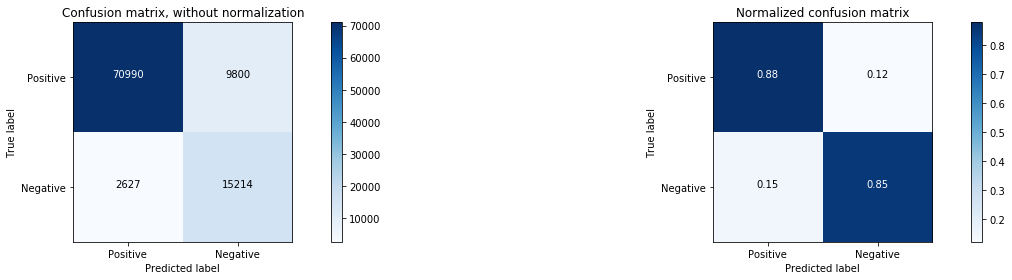

In [34]:
plot_confusion_matrix(rs_l2_bow_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 87% which is worse than the baseline Naive Bayes Model.
  2. 85% of negative reviews are captured with a precision of 61%, has a decent f1 score.
  3. Of the above 3 models, Bag of Words with L2 regularization seems to be good.

In [113]:
# ========================================== Most Important features ===========================================================
print_top10(count_vec, model_rs_l2_bow, n=10)

	-0.0396	great          		0.0288	tast           
	-0.0336	love           		0.0284	product        
	-0.0195	best           		0.0186	disappoint     
	-0.0173	good           		0.0157	like           
	-0.0132	use            		0.0156	bad            
	-0.0130	delici         		0.0142	box            
	-0.0129	make           		0.0123	did            
	-0.0112	perfect        		0.0121	money          
	-0.0106	tea            		0.0119	order          
	-0.0102	favorit        		0.0118	review         


### =========================== TFIDF Logistic Regression Model ==================================

### Logistic Regression Model with TFIDF features,Grid Search CV & L1 regularization

In [15]:
# ========================================== Model with TF-IDF features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l1'],'alpha': [10 ** x for x in range(-4, 5)]} 
gs_l1_tfidf_model = GridSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,scoring ='f1',cv = tscv)

gs_l1_tfidf_model.fit(X,Y)
print(gs_l1_tfidf_model.best_estimator_)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [16]:
tscv_scores = gs_l1_tfidf_model.cv_results_.get('mean_test_score')
trcv_scores = gs_l1_tfidf_model.cv_results_.get('mean_train_score')

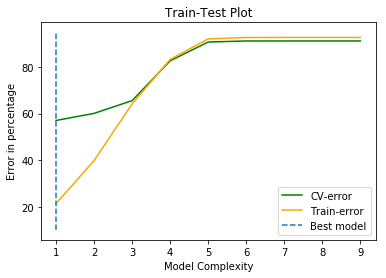

In [17]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(1,9),[10,91,92,93,93.5,94,94.6,94.7,95] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 0.0001. So, picking up the model with alpha = 0.0001

Let us see if there is any multicolinearity in the model. This can be verified by checking variance/ standard deviation of each coefficients that we get by building models with (alpha = 0.0001) random selection of data points from training data.

In [18]:
# =========================================== Multicollinearity Test ===========================================================
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 0.0001, penalty = 'l1')
coeff = []
for i in list(range(0,10)):
    tr_x,x_test,tr_y,y_test = train_test_split(X,Y,test_size = 0.2, random_state = None)
    model = classifier_name.fit(tr_x,tr_y)
    coeff.append(model.coef_[0])
coeff_df = pd.DataFrame(coeff,columns = tfidf_vec.get_feature_names())
coeff_df

,aaa,aaa don,aaaa,aaaaa,aaaaaa,aaaaaah,aaaaah,aaaah,aaaand,aaah,...,zupreem hay,zurich,zwieback,zwieback toast,zylitol,zym,zyrtec,zzz,zzzzz,zzzzzzz
0,-130.089333,0.000000,-22.356635,-0.391270,-113.579561,0.000000,-72.053140,-11.303869,-122.781955,-17.049220,...,0.000000,0.000000,-795.473802,0.000000,32.933280,-84.982287,-75.201915,0.000000,0.000000,0.000000
1,-15.731488,0.000000,-29.779365,-70.316713,0.000000,0.000000,0.000000,0.000000,-8.495443,-65.902206,...,-6.039830,-7.945689,-41.182177,-28.568378,111.379447,-9.951578,-240.688516,0.000000,-43.914182,0.000000
2,-15.730640,45.965952,-18.836269,1.901544,0.000000,0.000000,0.000000,0.000000,-23.864167,0.000000,...,-29.925453,0.000000,110.104064,576.814242,-0.847991,-170.128023,-41.007634,-1323.048123,-42.766266,-58.556537
3,-21.831028,0.000000,-56.313751,-1.182804,-63.557974,0.000000,0.000000,0.000000,-37.880768,-34.480965,...,-44.119924,0.000000,-68.113160,-4.609278,738.120503,0.000000,0.000000,-0.747189,-4.901681,0.000000
4,-39.078623,24.073761,-315.182633,-161.582569,0.000000,0.000000,-31.932845,0.000000,-7.439414,0.000000,...,-29.878332,0.000000,-265.416575,0.000000,-33.767360,0.000000,-0.851068,-5.837280,-39.717731,0.000000
5,-41.210484,-58.863265,-94.860334,-5.052708,-64.294587,0.000000,0.000000,-16.886077,-9.711779,-20.206099,...,0.000000,0.000000,-39.709347,-15.238449,69.792340,0.000000,0.000000,0.000000,-34.110910,0.000000
6,-44.413370,120.025734,-0.137813,45.354840,0.000000,0.000000,0.000000,-83.911842,0.000000,-199.440334,...,0.000000,-15.901098,-57.380323,-22.981709,-21.923808,-8.397349,0.000000,0.000000,-30.732238,-2.855750
7,-195.217936,-26.097197,-0.326589,35.039490,-24.458415,0.000000,0.000000,0.000000,-57.180761,-66.113891,...,-79.882986,0.000000,0.000000,-4.830221,-7.611387,0.000000,-53.409024,0.000000,-23.660640,0.000000
8,-49.963150,0.000000,-31.663969,-3.604920,0.000000,-12.137529,0.000000,-3.765274,0.000000,-25.531624,...,-0.139338,0.000000,-241.323877,0.000000,107.990380,0.000000,-8.743294,0.000000,0.000000,0.000000
9,-56.071823,0.000000,-33.552903,0.000000,0.000000,-22.072370,-52.970993,-127.032465,-22.305018,-0.150812,...,0.000000,-255.132058,4.316934,17.415878,57.129810,-44.191465,-30.720991,0.000000,-15.261856,-3.614028


In [19]:
print(coeff_df.std(axis=0).sort_values(ascending=False))

foot bar            5438.258056
cathedr             4845.680094
wash old            4781.814460
diseas warn         4630.820736
oppenheim           4625.339222
sinc guest          4565.467103
slight ding         4522.059906
worth increas       4521.113238
recommend welcom    4457.875928
overcook veri       4369.257646
ounc steak          4285.565445
anticip eager       4270.819383
hour ugh            4268.643262
label milder        4245.626398
bowl care           4218.507213
shot freez          4203.068405
noth let            4182.906118
nabisco snack       4173.086466
onli earth          4143.902525
chose away          4110.596336
like sentiment      4107.361242
velveeta kraft      4106.692364
unfortun hershey    4100.414620
gave grade          4076.640629
feast short         4034.112998
textur afraid       3998.308134
babi roach          3996.055761
nesquik anymor      3990.400168
isn tuna            3985.076554
possibl nastiest    3980.678320
                       ...     
pub rest

In [85]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(tfidf_words)
tfidf_words_tst1 = tfidf_vec.transform(test['cleaned_sent'].values)
tfidf_words_tst = X_scaler.transform(tfidf_words_tst1)
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 0.0001\
                                , penalty = 'l1')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_l1_tfidf = classifier_name.fit(train_X,train_y)
predtest_y_gs_l1_tfidf = model_gs_l1_tfidf.predict(tfidf_words_tst)

# Accuracy score
gs_l1_acc_tfidf = accuracy_score(test_y, predtest_y_gs_l1_tfidf, normalize=True)*100
print("Test Accuracy for Logistic Regression model with TF-IDF:",gs_l1_acc_tfidf,'%')
# Precision-Recall, f-score
gs_l1_tfidf_pre, gs_l1_tfidf_recall, gs_l1_tfidf_fscore, gs_l1_tfidf_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_l1_tfidf,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with TF-IDF for Negative label reviews:",gs_l1_tfidf_pre)
print("Test Recall for Logistic Regression model with TF-IDF for Negative label reviews:",gs_l1_tfidf_recall)
print("Test fscore for Logistic Regression model with TF-IDF for Negative label reviews:",gs_l1_tfidf_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_l1_tfidf, pos_label = 1)
gs_l1_tfidf_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with TF-IDF:",gs_l1_tfidf_auc_score)
# Confusion matrix
gs_l1_tfidf_cm = confusion_matrix(test_y, predtest_y_gs_l1_tfidf)

Test Accuracy for Logistic Regression model with TF-IDF: 74.08624063428334 %
Test Precision for Logistic Regression model with TF-IDF for Negative label reviews: 0.3770940824256322
Test Recall for Logistic Regression model with TF-IDF for Negative label reviews: 0.6636399304971694
Test fscore for Logistic Regression model with TF-IDF for Negative label reviews: 0.48091959625500114
Test AUC for Logistic Regression model with TF-IDF: 0.7107777570545013


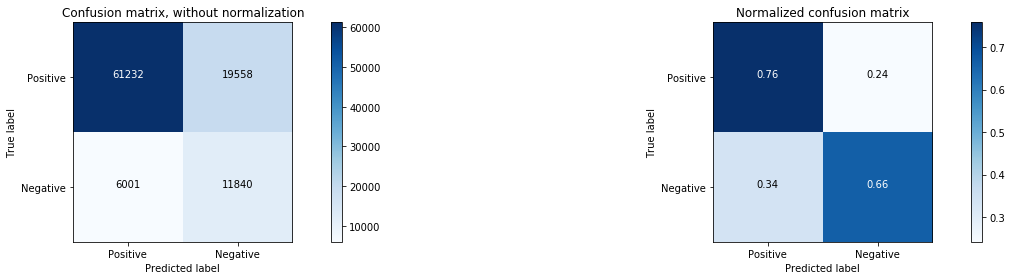

In [40]:
plot_confusion_matrix(gs_l1_tfidf_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 71% which is worse than the baseline Naive Bayes Model.
  2. Only 66% of negative reviews are captured with a poor precision of 38%.
  3. Of the above models, Bag of Words with L2 regularization seems to be good.

In [41]:
# ========================================== Most Important features ===========================================================
print_top10(count_vec, model_gs_l1_tfidf, n=10)

	-2297.4762	healdsburg     		10003.5204	abu            
	-1923.5225	spitter        		9829.7184	spoken         
	-1858.1068	babywuvinc     		9136.8910	gumballmachin  
	-1784.5058	anchoni        		8452.1257	ironb          
	-1764.0923	gekauft        		8135.2909	shoosh         
	-1761.8675	petdirectdotcom		7956.1568	spago          
	-1756.4027	anatagon       		7703.2402	pecto          
	-1740.5892	devist         		7562.2631	clemetin       
	-1717.3257	delhi          		7489.7146	oti            
	-1689.9943	thimothi       		7019.6568	barnum         


### Logistic Regression Model with TFIDF features,Grid Search CV & L2 regularization

In [46]:
# ========================================== Model with TF-IDF features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l2'],'alpha': [10 ** x for x in range(-4, 5)]} 
gs_l2_tfidf_model = GridSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,scoring ='f1',cv = tscv)

gs_l2_tfidf_model.fit(X,Y)
print(gs_l2_tfidf_model.best_estimator_)

SGDClassifier(alpha=10, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [47]:
tscv_scores = gs_l2_tfidf_model.cv_results_.get('mean_test_score')
trcv_scores = gs_l2_tfidf_model.cv_results_.get('mean_train_score')

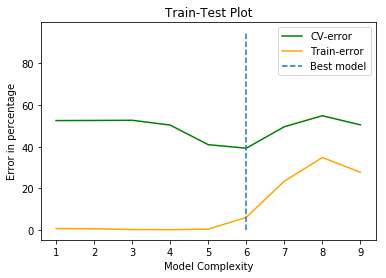

In [48]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(6,9),[0,91,92,93,93.5,94,94.6,94.7,95] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 10. So, picking up the model with alpha = 10

Let us see if there is any multicolinearity in the model. This can be verified by checking variance/ standard deviation of each coefficients that we get by building models with (alpha = 10) random selection of data points from training data.

In [49]:
# =========================================== Multicollinearity Test ===========================================================
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 10, penalty = 'l2')
coeff = []
for i in list(range(0,10)):
    tr_x,x_test,tr_y,y_test = train_test_split(X,Y,test_size = 0.2, random_state = None)
    model = classifier_name.fit(tr_x,tr_y)
    coeff.append(model.coef_[0])
coeff_df = pd.DataFrame(coeff,columns = tfidf_vec.get_feature_names())
coeff_df

,aaa,aaa don,aaaa,aaaaa,aaaaaa,aaaaaah,aaaaah,aaaah,aaaand,aaah,...,zupreem hay,zurich,zwieback,zwieback toast,zylitol,zym,zyrtec,zzz,zzzzz,zzzzzzz
0,-0.000187,0.000102,-0.000175,0.000053,-0.000092,-0.000047,-0.000055,-0.000080,-0.000083,-0.000144,...,-0.000086,-0.000029,-0.000083,0.000099,0.000047,-0.000124,-0.000110,-0.000109,-0.000053,0.000196
1,-0.000090,0.000167,-0.000147,-0.000009,-0.000032,-0.000093,-0.000057,-0.000085,-0.000084,-0.000165,...,-0.000087,-0.000112,-0.000060,0.000092,0.000030,-0.000128,-0.000124,-0.000103,-0.000098,-0.000033
2,-0.000139,0.000098,-0.000149,-0.000076,-0.000091,-0.000090,-0.000039,-0.000086,-0.000032,-0.000162,...,-0.000075,-0.000110,-0.000035,0.000145,0.000150,-0.000127,-0.000109,-0.000088,-0.000100,-0.000034
3,-0.000195,0.000000,-0.000147,0.000033,-0.000092,-0.000089,-0.000095,-0.000082,-0.000059,-0.000147,...,-0.000086,-0.000069,-0.000055,0.000102,0.000243,-0.000103,-0.000048,-0.000038,-0.000045,0.000203
4,-0.000132,0.000101,-0.000147,-0.000001,-0.000092,-0.000090,0.000000,-0.000016,-0.000085,-0.000087,...,-0.000083,-0.000082,-0.000023,0.000103,0.000159,-0.000099,-0.000123,-0.000114,-0.000097,0.000199
5,-0.000176,0.000105,-0.000103,-0.000017,-0.000093,-0.000090,-0.000094,-0.000083,-0.000080,-0.000062,...,-0.000086,-0.000070,0.000004,0.000102,0.000234,-0.000077,-0.000125,-0.000045,-0.000098,0.000240
6,-0.000230,0.000000,-0.000120,0.000035,-0.000093,-0.000089,-0.000097,-0.000085,-0.000057,-0.000100,...,-0.000089,-0.000111,-0.000159,-0.000068,0.000266,-0.000072,-0.000124,-0.000112,-0.000045,0.000209
7,-0.000187,0.000166,-0.000162,-0.000136,-0.000093,-0.000045,-0.000096,-0.000085,-0.000086,-0.000107,...,-0.000087,-0.000085,-0.000055,0.000101,0.000254,-0.000082,-0.000123,-0.000112,-0.000046,0.000204
8,-0.000196,0.000166,-0.000086,-0.000016,-0.000092,0.000000,-0.000095,-0.000017,-0.000084,-0.000174,...,-0.000085,-0.000108,-0.000104,-0.000073,0.000250,-0.000126,-0.000091,-0.000046,-0.000096,0.000201
9,-0.000112,0.000113,-0.000134,-0.000081,-0.000031,-0.000092,-0.000054,-0.000018,0.000000,-0.000175,...,-0.000088,-0.000112,-0.000158,-0.000071,0.000211,-0.000126,-0.000126,-0.000080,-0.000100,0.000210


In [50]:
print(coeff_df.std(axis=0).sort_values(ascending=False))

doubl regular       2.228395e-04
inferior origin     2.193731e-04
money poor          2.187098e-04
cooki trail         2.183697e-04
howev disgust       2.147393e-04
like tortuga        2.106865e-04
vomit day           2.096736e-04
chewer year         2.094970e-04
threw worth         2.092078e-04
price link          2.080233e-04
better mixtur       2.079430e-04
ewwwww              2.079395e-04
kind wine           2.077180e-04
contain chunk       2.075813e-04
plastic sure        2.067878e-04
product danger      2.065360e-04
product gross       2.058427e-04
cracker crush       2.054203e-04
big fli             2.052828e-04
melon tast          2.050686e-04
onli outdoor        2.047322e-04
bulgaria            2.046199e-04
compani nestl       2.043572e-04
look blueberri      2.042088e-04
mapl fudg           2.032978e-04
jet tea             2.031111e-04
buy desper          2.030326e-04
away afraid         2.025925e-04
onz                 2.021978e-04
yuck buy            2.021184e-04
          

In [86]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(tfidf_words)
tfidf_words_tst1 = tfidf_vec.transform(test['cleaned_sent'].values)
tfidf_words_tst = X_scaler.transform(tfidf_words_tst1)
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 10\
                                , penalty = 'l2')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_l2_tfidf = classifier_name.fit(train_X,train_y)
predtest_y_gs_l2_tfidf = model_gs_l2_tfidf.predict(tfidf_words_tst)

# Accuracy score
gs_l2_acc_tfidf = accuracy_score(test_y, predtest_y_gs_l2_tfidf, normalize=True)*100
print("Test Accuracy for Logistic Regression model with TF-IDF:",gs_l2_acc_tfidf,'%')
# Precision-Recall, f-score
gs_l2_tfidf_pre, gs_l2_tfidf_recall, gs_l2_tfidf_fscore, gs_l2_tfidf_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_l2_tfidf,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with TF-IDF for Negative label reviews:",gs_l2_tfidf_pre)
print("Test Recall for Logistic Regression model with TF-IDF for Negative label reviews:",gs_l2_tfidf_recall)
print("Test fscore for Logistic Regression model with TF-IDF for Negative label reviews:",gs_l2_tfidf_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_l2_tfidf, pos_label = 1)
gs_l2_tfidf_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with TF-IDF:",gs_l2_tfidf_auc_score)
# Confusion matrix
gs_l2_tfidf_cm = confusion_matrix(test_y, predtest_y_gs_l2_tfidf)

Test Accuracy for Logistic Regression model with TF-IDF: 84.37610893126907 %
Test Precision for Logistic Regression model with TF-IDF for Negative label reviews: 0.5432331495642895
Test Recall for Logistic Regression model with TF-IDF for Negative label reviews: 0.8560618799394653
Test fscore for Logistic Regression model with TF-IDF for Negative label reviews: 0.6646792584210984
Test AUC for Logistic Regression model with TF-IDF: 0.8485532818437269


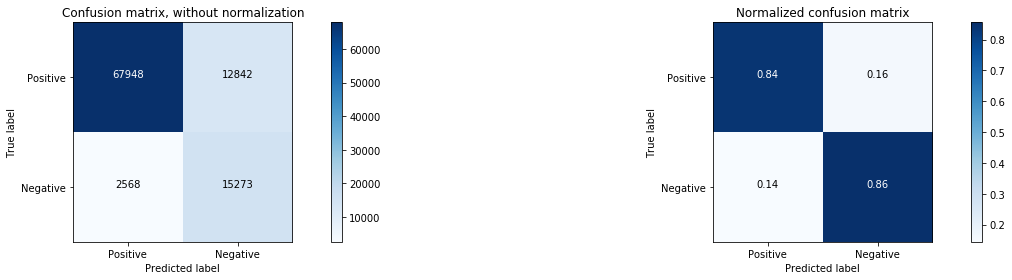

In [43]:
plot_confusion_matrix(gs_l2_tfidf_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 85% which is better than the baseline Naive Bayes Model.
  2. Only 86% of negative reviews are captured with a poor precision of 54%.
  3. Of the above models, Bag of Words with L2 regularization seems to be good.

In [44]:
# ========================================== Most Important features ===========================================================
print_top10(count_vec, model_gs_l2_tfidf, n=10)

	-0.0010	absolutuley    		0.0028	podravka       
	-0.0009	swimmer        		0.0025	prefrozen      
	-0.0009	alci           		0.0020	organza        
	-0.0009	trusti         		0.0017	onezip         
	-0.0008	adder          		0.0015	fordeliveri    
	-0.0008	makin          		0.0015	alfalfa        
	-0.0008	franchis       		0.0014	vecchia        
	-0.0008	unrival        		0.0013	almsot         
	-0.0008	errat          		0.0013	mayfield       
	-0.0008	adevrtis       		0.0013	diminisht      


### Logistic Regression Model with TFIDF features,Random Search CV & L1 regularization

In [35]:
# ========================================== Model with TFIDF features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l1'],'alpha': np.random.uniform(10**-2,10**2,10)}
rs_l1_tfidf_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions =  param,scoring ='f1',cv = tscv)

rs_l1_tfidf_model.fit(X,Y)
print(rs_l1_tfidf_model.best_estimator_)

SGDClassifier(alpha=6.7807609096530435, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l1', power_t=0.5, random_state=100,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [36]:
tscv_scores = rs_l1_tfidf_model.cv_results_.get('mean_test_score')
trcv_scores = rs_l1_tfidf_model.cv_results_.get('mean_train_score')

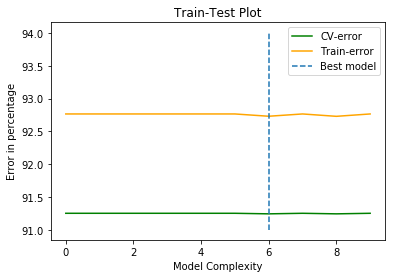

In [40]:
# Bias-Variance plot
x = [0,1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(6,9),[91,91.5,92,93,93.5,93.8,94,94.01,94.012] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 6.7807609096530435. So, picking up the model with alpha = 6.7807609096530435

Let us see if there is any multicolinearity in the model. This can be verified by checking variance/ standard deviation of each coefficients that we get by building models with (alpha = 6.7807609096530435) random selection of data points from training data.

In [41]:
# =========================================== Multicollinearity Test ===========================================================
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 6.7807609096530435\
                                , penalty = 'l1')
coeff = []
for i in list(range(0,10)):
    tr_x,x_test,tr_y,y_test = train_test_split(X,Y,test_size = 0.2, random_state = None)
    model = classifier_name.fit(tr_x,tr_y)
    coeff.append(model.coef_[0])
coeff_df = pd.DataFrame(coeff,columns = tfidf_vec.get_feature_names())
coeff_df

,aaa,aaa don,aaaa,aaaaa,aaaaaa,aaaaaah,aaaaah,aaaah,aaaand,aaah,...,zupreem hay,zurich,zwieback,zwieback toast,zylitol,zym,zyrtec,zzz,zzzzz,zzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
print(coeff_df.std(axis=0).sort_values(ascending=False))

walgreen com        137.207229
gerber rice          81.550445
search result        69.092311
com search           61.531129
size exact           60.070914
differ pack          50.908492
buy equival          49.348452
produt               29.561497
search search        22.451345
care unless          22.047979
walgreen             20.783070
pack size            20.415941
web link             20.140029
color end            19.703883
larg thank           18.918363
engin think          17.671310
core piec            17.609716
caviar just          17.356693
facil onli           17.122883
outstand want        17.057548
handi lunch          17.010614
describ almond       16.732661
vinegar sharp        16.572010
descript terribl     16.520166
littl bucket         16.446682
did graini           16.297652
cardboard bar        15.995988
veri pink            15.668010
http www             15.374892
bland make           14.978207
                       ...    
potato organ          0.000000
potato o

In [87]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(tfidf_words)
tfidf_words_tst1 = tfidf_vec.transform(test['cleaned_sent'].values)
tfidf_words_tst = X_scaler.transform(tfidf_words_tst1)
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 6.7807609096530435\
                                , penalty = 'l1')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_l1_tfidf = classifier_name.fit(train_X,train_y)
predtest_y_rs_l1_tfidf = model_rs_l1_tfidf.predict(tfidf_words_tst)

# Accuracy score
rs_l1_acc_tfidf = accuracy_score(test_y, predtest_y_rs_l1_tfidf, normalize=True)*100
print("Test Accuracy for Logistic Regression model with TF-IDF:",rs_l1_acc_tfidf,'%')
# Precision-Recall, f-score
rs_l1_tfidf_pre, rs_l1_tfidf_recall, rs_l1_tfidf_fscore, rs_l1_tfidf_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_l1_tfidf,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with TF-IDF for Negative label reviews:",rs_l1_tfidf_pre)
print("Test Recall for Logistic Regression model with TF-IDF for Negative label reviews:",rs_l1_tfidf_recall)
print("Test fscore for Logistic Regression model with TF-IDF for Negative label reviews:",rs_l1_tfidf_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_l1_tfidf, pos_label = 1)
rs_l1_tfidf_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with TF-IDF:",rs_l1_tfidf_auc_score)
# Confusion matrix
rs_l1_tfidf_cm = confusion_matrix(test_y, predtest_y_rs_l1_tfidf)

Test Accuracy for Logistic Regression model with TF-IDF: 81.9113666088755 %
Test Precision for Logistic Regression model with TF-IDF for Negative label reviews: 0.0
Test Recall for Logistic Regression model with TF-IDF for Negative label reviews: 0.0
Test fscore for Logistic Regression model with TF-IDF for Negative label reviews: 0.0
Test AUC for Logistic Regression model with TF-IDF: 0.5


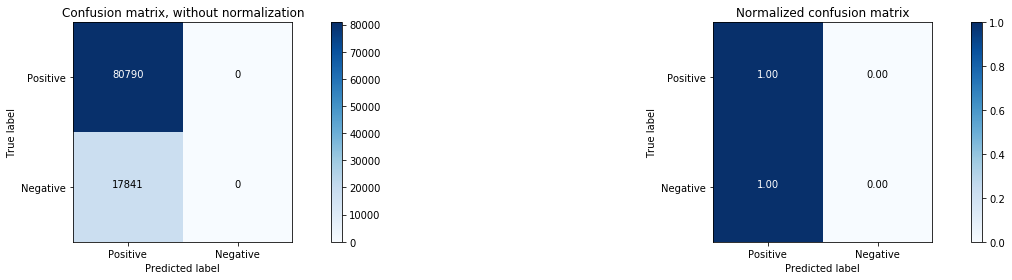

In [46]:
plot_confusion_matrix(rs_l1_tfidf_cm, ['Positive','Negative'])

In [49]:
# % Zero weight features
(model_rs_l1_tfidf.coef_==0).sum()/(model_rs_l1_tfidf.coef_).size

0.9999751338627058

#### Observation:
  1. Best AUC that we have achieved is 50% which is worse than the baseline Naive Bayes Model, that means the model is a constant model, predicts all as Positive review.
  2. 0% of negative reviews are captured with a precision of 0%.
  3. Of the above models, Bag of Words with L2 regularization (grid search) seems to be good.
  4. All features weights are zero.

In [47]:
# ========================================== Most Important features ===========================================================
print_top10(count_vec, model_rs_l1_tfidf, n=10)

	0.0000	aaa            		0.0000	zzzzzzzzzzz    
	0.0000	aaaa           		0.0000	zzzzzzzzzz     
	0.0000	aaaaa          		0.0000	zzzzzzzz       
	0.0000	aaaaaa         		0.0000	zzzzzzz        
	0.0000	aaaaaaaaaaa    		0.0000	zzzzz          
	0.0000	aaaaaaaaaaaa   		0.0000	zzz            
	0.0000	aaaaaaaaaaaaa  		0.0000	zziga          
	0.0000	aaaaaaaaaaaaaaa		0.0000	zyto           
	0.0000	aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa		0.0000	zyrtec         
	0.0000	aaaaaaaaaaaaaaaaaaaargh		0.0000	zypan          


### Logistic Regression Model with TFIDF features,Random Search CV & L2 regularization

In [53]:
# ========================================== Model with TF-IDF features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l2'],'alpha': np.random.uniform(10**-2,10**2,10)}
rs_l2_tfidf_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions =  param,scoring ='f1',cv = tscv)

rs_l2_tfidf_model.fit(X,Y)
print(rs_l2_tfidf_model.best_estimator_)

SGDClassifier(alpha=3.80638057235097, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [54]:
tscv_scores = rs_l2_tfidf_model.cv_results_.get('mean_test_score')
trcv_scores = rs_l2_tfidf_model.cv_results_.get('mean_train_score')

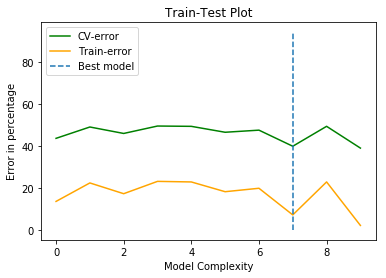

In [58]:
# Bias-Variance plot
x = [0,1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(7,9),[0,91.5,92,93,93.5,93.8,94,94.01,94.012] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 3.80638057235097. So, picking up the model with alpha = 3.80638057235097

Let us see if there is any multicolinearity in the model. This can be verified by checking variance/ standard deviation of each coefficients that we get by building models with (alpha = 3.80638057235097) random selection of data points from training data.

In [56]:
# =========================================== Multicollinearity Test ===========================================================
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha =3.80638057235097 \
                                , penalty = 'l2')
coeff = []
for i in list(range(0,10)):
    tr_x,x_test,tr_y,y_test = train_test_split(X,Y,test_size = 0.2, random_state = None)
    model = classifier_name.fit(tr_x,tr_y)
    coeff.append(model.coef_[0])
coeff_df = pd.DataFrame(coeff,columns = tfidf_vec.get_feature_names())
coeff_df

,aaa,aaa don,aaaa,aaaaa,aaaaaa,aaaaaah,aaaaah,aaaah,aaaand,aaah,...,zupreem hay,zurich,zwieback,zwieback toast,zylitol,zym,zyrtec,zzz,zzzzz,zzzzzzz
0,-0.000554,-0.000155,-0.000384,0.000136,-0.000137,-0.000092,-0.000211,-0.000123,-0.000157,-0.000220,...,0.000000,-0.000171,-0.000269,-0.000097,0.000574,-0.000224,-0.000166,-0.000095,-0.000219,0.000361
1,-0.000511,0.000299,-0.000395,0.000017,-0.000193,-0.000177,-0.000189,-0.000183,-0.000187,-0.000216,...,-0.000206,-0.000127,-0.000192,0.000165,0.000459,-0.000147,-0.000103,-0.000218,-0.000221,0.000396
2,-0.000519,0.000137,-0.000390,-0.000265,-0.000192,-0.000186,-0.000130,-0.000182,-0.000175,-0.000331,...,-0.000213,-0.000229,-0.000194,0.000153,0.000160,-0.000275,-0.000251,-0.000075,-0.000239,0.000368
3,-0.000425,0.000000,-0.000341,-0.000215,-0.000199,-0.000199,-0.000218,-0.000187,-0.000176,-0.000356,...,-0.000208,-0.000217,-0.000080,0.000319,0.000373,-0.000272,-0.000182,-0.000240,-0.000116,0.000352
4,-0.000378,0.000107,-0.000427,0.000101,-0.000196,-0.000168,0.000000,-0.000178,-0.000164,-0.000331,...,-0.000214,-0.000216,-0.000183,0.000180,0.000248,-0.000279,-0.000247,-0.000225,-0.000208,-0.000061
5,-0.000443,0.000128,-0.000432,-0.000004,-0.000192,-0.000168,-0.000201,-0.000024,-0.000172,-0.000266,...,-0.000228,-0.000132,-0.000116,0.000175,0.000393,-0.000146,-0.000195,-0.000259,-0.000219,0.000372
6,-0.000502,0.000181,-0.000333,0.000172,-0.000196,-0.000165,-0.000207,-0.000154,-0.000060,-0.000241,...,-0.000204,-0.000223,-0.000198,0.000128,0.000419,-0.000268,-0.000104,-0.000199,-0.000118,0.000432
7,-0.000404,-0.000153,-0.000431,0.000175,-0.000200,-0.000090,-0.000202,-0.000156,-0.000048,-0.000358,...,-0.000210,-0.000216,-0.000137,0.000145,0.000183,-0.000255,-0.000157,-0.000254,-0.000225,0.000359
8,-0.000500,0.000000,-0.000381,-0.000296,-0.000061,-0.000158,-0.000070,-0.000175,-0.000160,-0.000351,...,-0.000223,-0.000195,-0.000128,0.000174,0.000124,-0.000261,-0.000143,-0.000235,-0.000204,0.000338
9,-0.000401,0.000215,-0.000437,0.000011,0.000000,0.000000,-0.000196,-0.000158,-0.000103,-0.000304,...,-0.000187,-0.000218,-0.000121,0.000183,0.000393,-0.000089,-0.000253,-0.000241,-0.000214,0.000353


In [57]:
print(coeff_df.std(axis=0).sort_values(ascending=False))

hate better           0.000525
normali               0.000478
exact receiv          0.000476
isn line              0.000473
popchip howev         0.000473
babi figur            0.000468
expect intens         0.000467
cake know             0.000467
doesn vanilla         0.000463
enjoy guilti          0.000462
veri obes             0.000462
add cane              0.000460
earth jasmin          0.000457
turkey veg            0.000457
post place            0.000456
broke tini            0.000454
high opinion          0.000454
contain chunk         0.000453
like danc             0.000452
arriv bang            0.000451
ingredi finish        0.000451
averag buy            0.000451
howev crunchi         0.000450
discourag anyon       0.000449
fat chunk             0.000449
mocha close           0.000449
sauc england          0.000448
eaten tuna            0.000448
popchip box           0.000447
isn fun               0.000447
                        ...   
batch obsq            0.000002
fruiti b

In [88]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(tfidf_words)
tfidf_words_tst1 = tfidf_vec.transform(test['cleaned_sent'].values)
tfidf_words_tst = X_scaler.transform(tfidf_words_tst1)
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 3.80638057235097\
                                , penalty = 'l2')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_l2_tfidf = classifier_name.fit(train_X,train_y)
predtest_y_rs_l2_tfidf = model_rs_l2_tfidf.predict(tfidf_words_tst)

# Accuracy score
rs_l2_acc_tfidf = accuracy_score(test_y, predtest_y_rs_l2_tfidf, normalize=True)*100
print("Test Accuracy for Logistic Regression model with TF-IDF:",rs_l2_acc_tfidf,'%')
# Precision-Recall, f-score
rs_l2_tfidf_pre, rs_l2_tfidf_recall, rs_l2_tfidf_fscore, rs_l2_tfidf_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_l2_tfidf,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with TF-IDF for Negative label reviews:",rs_l2_tfidf_pre)
print("Test Recall for Logistic Regression model with TF-IDF for Negative label reviews:",rs_l2_tfidf_recall)
print("Test fscore for Logistic Regression model with TF-IDF for Negative label reviews:",rs_l2_tfidf_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_l2_tfidf, pos_label = 1)
rs_l2_tfidf_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with TF-IDF:",rs_l2_tfidf_auc_score)
# Confusion matrix
rs_l2_tfidf_cm = confusion_matrix(test_y, predtest_y_rs_l2_tfidf)

Test Accuracy for Logistic Regression model with TF-IDF: 87.86081455120602 %
Test Precision for Logistic Regression model with TF-IDF for Negative label reviews: 0.6326161634424154
Test Recall for Logistic Regression model with TF-IDF for Negative label reviews: 0.7844851745978364
Test fscore for Logistic Regression model with TF-IDF for Negative label reviews: 0.7004128612535968
Test AUC for Logistic Regression model with TF-IDF: 0.8419393319455328


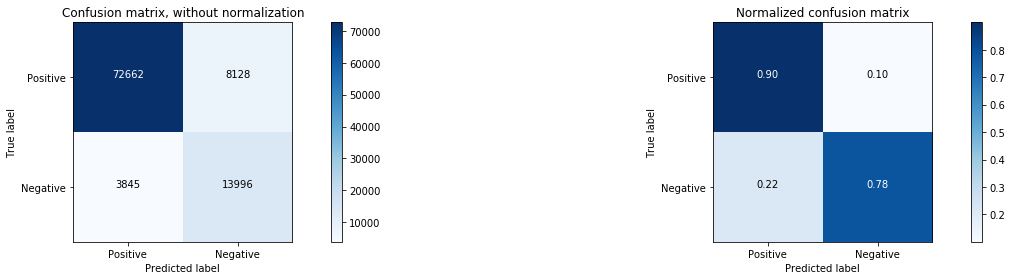

In [51]:
plot_confusion_matrix(rs_l2_tfidf_cm, ['Positive','Negative'])

In [54]:
# % Zero weight features
(model_rs_l2_tfidf.coef_==0).sum()/(model_rs_l2_tfidf.coef_).size

0.0

#### Observation:
  1. Best AUC that we have achieved is 84% which is better than the baseline Naive Bayes Model.
  2. Only 78% of negative reviews are captured with a poor precision of 63%.
  3. Of the above models, Bag of Words with L2 regularization seems to be good.

In [53]:
# ========================================== Most Important features ===========================================================
print_top10(count_vec, model_rs_l2_tfidf, n=10)

	-0.0022	absolutuley    		0.0049	podravka       
	-0.0021	swimmer        		0.0046	prefrozen      
	-0.0020	alci           		0.0037	organza        
	-0.0019	trusti         		0.0030	onezip         
	-0.0019	makin          		0.0026	alfalfa        
	-0.0018	adder          		0.0026	fordeliveri    
	-0.0017	franchis       		0.0025	almsot         
	-0.0017	fluazifop      		0.0025	alberti        
	-0.0017	errat          		0.0024	paper          
	-0.0017	adevrtis       		0.0024	vecchia        


### ======================== Avg. Word2Vec Logistic Regression Model ==============================

### Logistic Regression Model with Average Word2Vec,Grid Search CV & L1 regularization

In [15]:
# ========================================== Model with Average W2V features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = sent_vect[:train.shape[0]]
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l1'],'alpha': [10 ** x for x in range(-4, 5)]}
gs_l1_avgw2v_model = GridSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,scoring ='f1',cv = tscv)
gs_l1_avgw2v_model.fit(X,Y)

print(gs_l1_avgw2v_model.best_estimator_)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [16]:
tscv_scores = gs_l1_avgw2v_model.cv_results_.get('mean_test_score')
trcv_scores = gs_l1_avgw2v_model.cv_results_.get('mean_train_score')

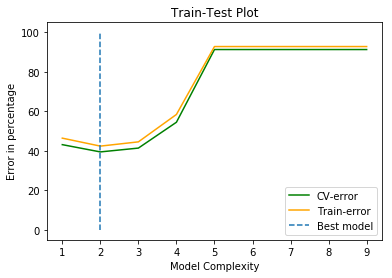

In [18]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(2,9),[0,3,5,8,10,12,16,17,100] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 0.001. So, picking up the model with alpha = 0.001

Word2Vec models doesn't have any features, instead it is just a vector representation of features (Sentence/words). Hence, there is no need to check multicollinearity and feature importance in the model.

In [89]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
tscv = TimeSeriesSplit(n_splits= 10)
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(sent_vect[:train.shape[0]])
avgw2v_tst = X_scaler.transform(sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 0.001, penalty = 'l1')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_l1_avgw2v = classifier_name.fit(train_X,train_y)
predtest_y_gs_l1_avgw2v = model_gs_l1_avgw2v.predict(avgw2v_tst)

# Accuracy score
gs_l1_acc_avgw2v = accuracy_score(test_y, predtest_y_gs_l1_avgw2v, normalize=True)*100
print("Test Accuracy for Logistic Regression model with Avg. Word2Vec:",gs_l1_acc_avgw2v,'%')
# Precision-Recall, f-score
gs_l1_avgw2v_pre, gs_l1_avgw2v_recall, gs_l1_avgw2v_fscore, gs_l1_avgw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_l1_avgw2v,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",gs_l1_avgw2v_pre)
print("Test Recall for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",gs_l1_avgw2v_recall)
print("Test fscore for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",gs_l1_avgw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_l1_avgw2v, pos_label = 1)
gs_l1_avgw2v_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with Avg. Word2Vec:",gs_l1_avgw2v_auc_score)
# Confusion matrix
gs_l1_avgw2v_cm = confusion_matrix(test_y, predtest_y_gs_l1_avgw2v)

Test Accuracy for Logistic Regression model with Avg. Word2Vec: 82.63831858137908 %
Test Precision for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.5118188111957275
Test Recall for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.8701866487304524
Test fscore for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.6445385477643543
Test AUC for Logistic Regression model with Avg. Word2Vec: 0.84344831879523


In [21]:
(model_gs_l1_avgw2v.coef_==0).sum()/(model_gs_l1_avgw2v.coef_).size

0.27

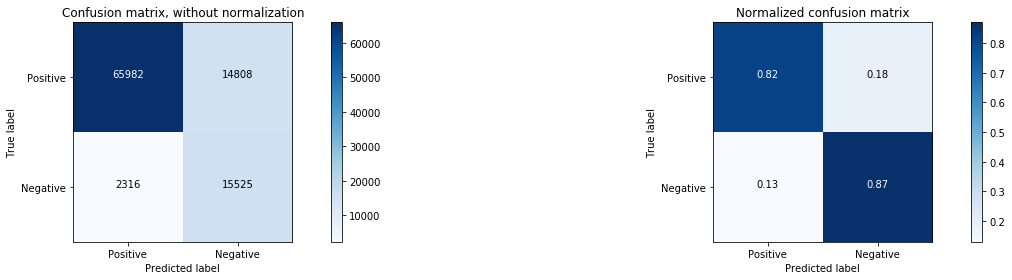

In [20]:
plot_confusion_matrix(gs_l1_avgw2v_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 84% which is better than the baseline Naive Bayes Model.
  2. 87% of negative reviews are captured with a poor precision of 51%.
  3. Of the above models, Bag of Words with L2 regularization seems to be good.

### Logistic Regression Model with Average Word2Vec,Grid Search CV & L2 regularization

In [23]:
# ========================================== Model with Average W2V features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = sent_vect[:train.shape[0]]
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l2'],'alpha': [10 ** x for x in range(-4, 5)]}
gs_l2_avgw2v_model = GridSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,scoring ='f1',cv = tscv)
gs_l2_avgw2v_model.fit(X,Y)

print(gs_l2_avgw2v_model.best_estimator_)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [24]:
tscv_scores = gs_l2_avgw2v_model.cv_results_.get('mean_test_score')
trcv_scores = gs_l2_avgw2v_model.cv_results_.get('mean_train_score')

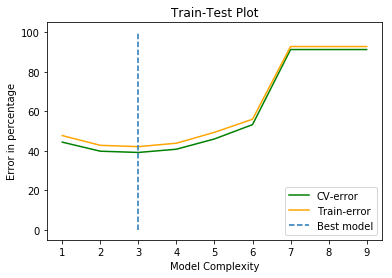

In [26]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(3,9),[0,3,5,8,10,12,16,17,100] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 0.01. So, picking up the model with alpha = 0.01

Word2Vec models doesn't have any features, instead it is just a vector representation of features (Sentence/words). Hence, there is no need to check multicollinearity and feature importance in the model.

In [90]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
tscv = TimeSeriesSplit(n_splits= 10)
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(sent_vect[:train.shape[0]])
avgw2v_tst = X_scaler.transform(sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 0.01, penalty = 'l2')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_l2_avgw2v = classifier_name.fit(train_X,train_y)
predtest_y_gs_l2_avgw2v = model_gs_l2_avgw2v.predict(avgw2v_tst)

# Accuracy score
gs_l2_acc_avgw2v = accuracy_score(test_y, predtest_y_gs_l2_avgw2v, normalize=True)*100
print("Test Accuracy for Logistic Regression model with Avg. Word2Vec:",gs_l2_acc_avgw2v,'%')
# Precision-Recall, f-score
gs_l2_avgw2v_pre, gs_l2_avgw2v_recall, gs_l2_avgw2v_fscore, gs_l2_avgw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_l2_avgw2v,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",gs_l2_avgw2v_pre)
print("Test Recall for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",gs_l2_avgw2v_recall)
print("Test fscore for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",gs_l2_avgw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_l2_avgw2v, pos_label = 1)
gs_l2_avgw2v_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with Avg. Word2Vec:",gs_l2_avgw2v_auc_score)
# Confusion matrix
gs_l2_avgw2v_cm = confusion_matrix(test_y, predtest_y_gs_l2_avgw2v)

Test Accuracy for Logistic Regression model with Avg. Word2Vec: 82.88773306566901 %
Test Precision for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.5160035895901884
Test Recall for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.8701866487304524
Test fscore for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.6478467701552328
Test AUC for Logistic Regression model with Avg. Word2Vec: 0.8449707844469195


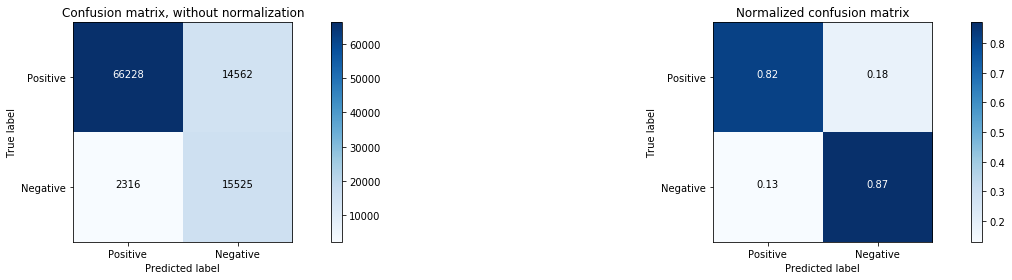

In [29]:
plot_confusion_matrix(gs_l2_avgw2v_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 83% which is better than the baseline Naive Bayes Model.
  2. 87% of negative reviews are captured with a poor precision of 52%.
  3. Of the above models, Bag of Words with L2 regularization seems to be good.

### Logistic Regression Model with Average Word2Vec,Random Search CV & L1 regularization

In [33]:
# ========================================== Model with Average W2V features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = sent_vect[:train.shape[0]]
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l1'],'alpha': np.random.uniform(10**-2,10**2,10)}
rs_l1_avgw2v_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions = param,scoring ='f1',cv = tscv)
rs_l1_avgw2v_model.fit(X,Y)

print(rs_l1_avgw2v_model.best_estimator_)

SGDClassifier(alpha=57.63937140738023, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [34]:
tscv_scores = rs_l1_avgw2v_model.cv_results_.get('mean_test_score')
trcv_scores = rs_l1_avgw2v_model.cv_results_.get('mean_train_score')

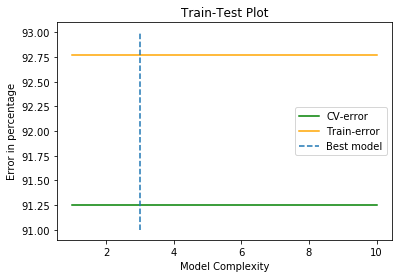

In [40]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9,10]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(3,10),[91,91,91.5,92,93,93,93,93,93,93] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 57.63937140738023. So, picking up the model with alpha = 57.63937140738023

Word2Vec models doesn't have any features, instead it is just a vector representation of features (Sentence/words). Hence, there is no need to check multicollinearity and feature importance in the model.

In [91]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
tscv = TimeSeriesSplit(n_splits= 10)
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(sent_vect[:train.shape[0]])
avgw2v_tst = X_scaler.transform(sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 57.63937140738023\
                                , penalty = 'l1')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_l1_avgw2v = classifier_name.fit(train_X,train_y)
predtest_y_rs_l1_avgw2v = model_rs_l1_avgw2v.predict(avgw2v_tst)

# Accuracy score
rs_l1_acc_avgw2v = accuracy_score(test_y, predtest_y_rs_l1_avgw2v, normalize=True)*100
print("Test Accuracy for Logistic Regression model with Avg. Word2Vec:",rs_l1_acc_avgw2v,'%')
# Precision-Recall, f-score
rs_l1_avgw2v_pre, rs_l1_avgw2v_recall, rs_l1_avgw2v_fscore, rs_l1_avgw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_l1_avgw2v,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",rs_l1_avgw2v_pre)
print("Test Recall for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",rs_l1_avgw2v_recall)
print("Test fscore for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",rs_l1_avgw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_l1_avgw2v, pos_label = 1)
rs_l1_avgw2v_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with Avg. Word2Vec:",rs_l1_avgw2v_auc_score)
# Confusion matrix
rs_l1_avgw2v_cm = confusion_matrix(test_y, predtest_y_rs_l1_avgw2v)

Test Accuracy for Logistic Regression model with Avg. Word2Vec: 81.9113666088755 %
Test Precision for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.0
Test Recall for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.0
Test fscore for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.0
Test AUC for Logistic Regression model with Avg. Word2Vec: 0.5


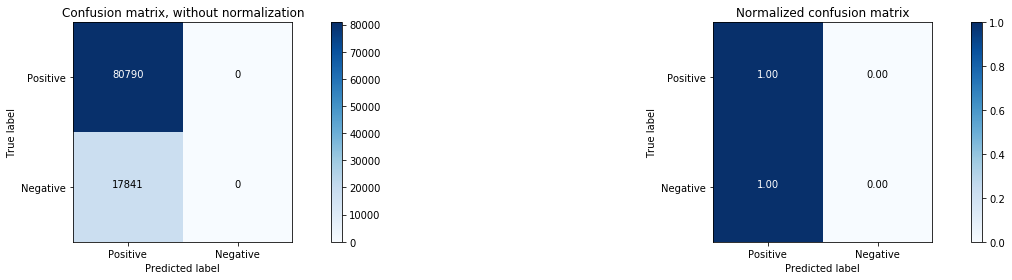

In [41]:
plot_confusion_matrix(rs_l1_avgw2v_cm, ['Positive','Negative'])

In [42]:
# % Zero weight features
(model_rs_l1_avgw2v.coef_==0).sum()/(model_rs_l1_avgw2v.coef_).size

1.0

#### Observation:
  1. Best AUC that we have achieved is 50% which is worse than the baseline Naive Bayes Model, that means the model is a constant model, predicts all as Positive review.
  2. 0% of negative reviews are captured with a precision of 0%.
  3. Of the above models, Bag of Words with L2 regularization (grid search) seems to be good.
  4. All features weights are zero.

### Logistic Regression Model with Average Word2Vec,Random Search CV & L2 regularization

In [43]:
# ========================================== Model with Average W2V features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = sent_vect[:train.shape[0]]
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l2'],'alpha': np.random.uniform(10**-2,10**2,10)}
rs_l2_avgw2v_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions = param,scoring ='f1',cv = tscv)
rs_l2_avgw2v_model.fit(X,Y)

print(rs_l2_avgw2v_model.best_estimator_)

SGDClassifier(alpha=1.7559056058667681, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=100,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [44]:
tscv_scores = rs_l2_avgw2v_model.cv_results_.get('mean_test_score')
trcv_scores = rs_l2_avgw2v_model.cv_results_.get('mean_train_score')

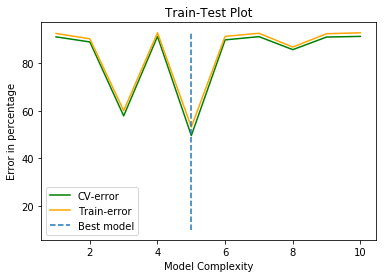

In [47]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9,10]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(5,10),[10,91,91.5,92,93,93,93,93,93,93] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 1.7559056058667681. So, picking up the model with alpha = 1.7559056058667681

Word2Vec models doesn't have any features, instead it is just a vector representation of features (Sentence/words). Hence, there is no need to check multicollinearity and feature importance in the model.

In [92]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
tscv = TimeSeriesSplit(n_splits= 10)
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(sent_vect[:train.shape[0]])
avgw2v_tst = X_scaler.transform(sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 1.7559056058667681\
                                , penalty = 'l2')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_l2_avgw2v = classifier_name.fit(train_X,train_y)
predtest_y_rs_l2_avgw2v = model_rs_l2_avgw2v.predict(avgw2v_tst)

# Accuracy score
rs_l2_acc_avgw2v = accuracy_score(test_y, predtest_y_rs_l2_avgw2v, normalize=True)*100
print("Test Accuracy for Logistic Regression model with Avg. Word2Vec:",rs_l2_acc_avgw2v,'%')
# Precision-Recall, f-score
rs_l2_avgw2v_pre, rs_l2_avgw2v_recall, rs_l2_avgw2v_fscore, rs_l2_avgw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_l2_avgw2v,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",rs_l2_avgw2v_pre)
print("Test Recall for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",rs_l2_avgw2v_recall)
print("Test fscore for Logistic Regression model with Avg. Word2Vec for Negative label reviews:",rs_l2_avgw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_l2_avgw2v, pos_label = 1)
rs_l2_avgw2v_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with Avg. Word2Vec:",rs_l2_avgw2v_auc_score)
# Confusion matrix
rs_l2_avgw2v_cm = confusion_matrix(test_y, predtest_y_rs_l2_avgw2v)

Test Accuracy for Logistic Regression model with Avg. Word2Vec: 81.59909156350437 %
Test Precision for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.4947321611821851
Test Recall for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.8106608373970069
Test fscore for Logistic Regression model with Avg. Word2Vec for Negative label reviews: 0.6144662772172065
Test AUC for Logistic Regression model with Avg. Word2Vec: 0.8139144018647368


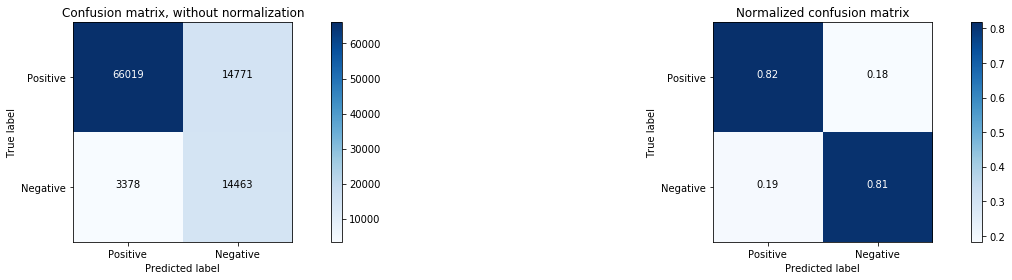

In [50]:
plot_confusion_matrix(rs_l2_avgw2v_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 81% which is better than the baseline Naive Bayes Model.
  2. 81% of negative reviews are captured with a poor precision of 49%.
  3. Of the above models, Bag of Words with L2 regularization seems to be good.

### ======================== TFIDF. Word2Vec Logistic Regression Model ============================

### Logistic Regression Model with TFIDF Word2Vec,Grid Search CV & L1 regularization

In [53]:
# ========================================== Model with TFIDF W2V features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = tfidf_sent_vect[:train.shape[0]]
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l1'],'alpha': [10 ** x for x in range(-4, 5)]}
gs_l1_tfidfw2v_model = GridSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,scoring ='f1',cv = tscv)
gs_l1_tfidfw2v_model.fit(X,Y)

print(gs_l1_tfidfw2v_model.best_estimator_)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [54]:
tscv_scores = gs_l1_tfidfw2v_model.cv_results_.get('mean_test_score')
trcv_scores = gs_l1_tfidfw2v_model.cv_results_.get('mean_train_score')

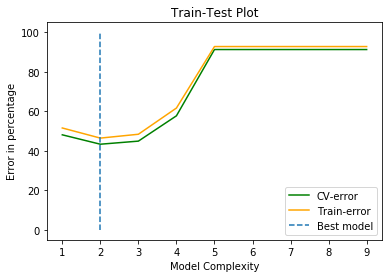

In [55]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(2,9),[0,3,5,8,10,12,16,17,100] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 0.001. So, picking up the model with alpha = 0.001

Word2Vec models doesn't have any features, instead it is just a vector representation of features (Sentence/words). Hence, there is no need to check multicollinearity and feature importance in the model.

In [93]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
tscv = TimeSeriesSplit(n_splits= 10)
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(tfidf_sent_vect[:train.shape[0]])
tfidfw2v_tst = X_scaler.transform(tfidf_sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 0.001\
                                , penalty = 'l1')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_l1_tfidfw2v = classifier_name.fit(train_X,train_y)
predtest_y_gs_l1_tfidfw2v = model_gs_l1_tfidfw2v.predict(tfidfw2v_tst)

# Accuracy score
gs_l1_acc_tfidfw2v = accuracy_score(test_y, predtest_y_gs_l1_tfidfw2v, normalize=True)*100
print("Test Accuracy for Logistic Regression model with TFIDF Word2Vec:",gs_l1_acc_tfidfw2v,'%')
# Precision-Recall, f-score
gs_l1_tfidfw2v_pre, gs_l1_tfidfw2v_recall, gs_l1_tfidfw2v_fscore, gs_l1_tfidfw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_l1_tfidfw2v,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",gs_l1_tfidfw2v_pre)
print("Test Recall for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",gs_l1_tfidfw2v_recall)
print("Test fscore for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",gs_l1_tfidfw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_l1_tfidfw2v, pos_label = 1)
gs_l1_tfidfw2v_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with TFIDF Word2Vec:",gs_l1_tfidfw2v_auc_score)
# Confusion matrix
gs_l1_tfidfw2v_cm = confusion_matrix(test_y, predtest_y_gs_l1_tfidfw2v)

Test Accuracy for Logistic Regression model with TFIDF Word2Vec: 80.92587523192505 %
Test Precision for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.48424737456242706
Test Recall for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.8373970068942324
Test fscore for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.6136405643521656
Test AUC for Logistic Regression model with TFIDF Word2Vec: 0.8202209690988058


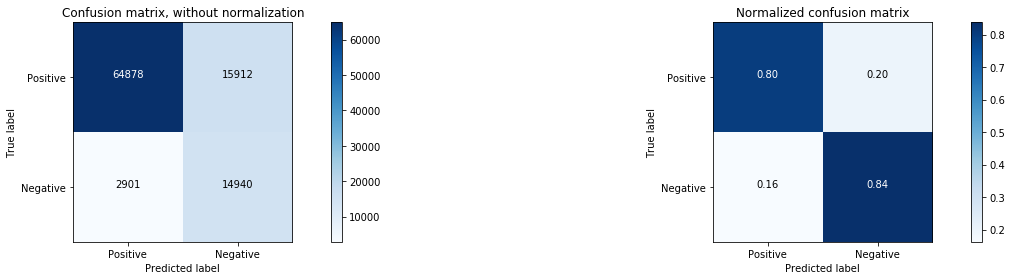

In [61]:
plot_confusion_matrix(gs_l1_tfidfw2v_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 82% which is better than the baseline Naive Bayes Model.
  2. 84% of negative reviews are captured with a poor precision of 48%.
  3. Of the above models, Bag of Words with L2 regularization seems to be good.

### Logistic Regression Model with TFIDF Word2Vec,Grid Search CV & L2 regularization

In [56]:
# ========================================== Model with TFIDF W2V features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = tfidf_sent_vect[:train.shape[0]]
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l2'],'alpha': [10 ** x for x in range(-4, 5)]}
gs_l2_tfidfw2v_model = GridSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,scoring ='f1',cv = tscv)
gs_l2_tfidfw2v_model.fit(X,Y)

print(gs_l2_tfidfw2v_model.best_estimator_)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [57]:
tscv_scores = gs_l2_tfidfw2v_model.cv_results_.get('mean_test_score')
trcv_scores = gs_l2_tfidfw2v_model.cv_results_.get('mean_train_score')

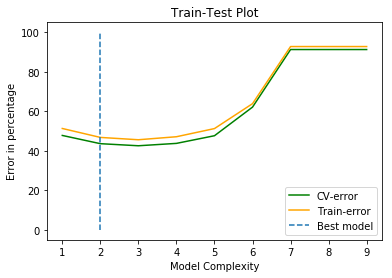

In [58]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(2,9),[0,3,5,8,10,12,16,17,100] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 0.01. So, picking up the model with alpha = 0.01

Word2Vec models doesn't have any features, instead it is just a vector representation of features (Sentence/words). Hence, there is no need to check multicollinearity and feature importance in the model.

In [94]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
tscv = TimeSeriesSplit(n_splits= 10)
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(tfidf_sent_vect[:train.shape[0]])
tfidfw2v_tst = X_scaler.transform(tfidf_sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 0.01\
                                , penalty = 'l2')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_l2_tfidfw2v = classifier_name.fit(train_X,train_y)
predtest_y_gs_l2_tfidfw2v = model_gs_l2_tfidfw2v.predict(tfidfw2v_tst)

# Accuracy score
gs_l2_acc_tfidfw2v = accuracy_score(test_y, predtest_y_gs_l2_tfidfw2v, normalize=True)*100
print("Test Accuracy for Logistic Regression model with TFIDF Word2Vec:",gs_l2_acc_tfidfw2v,'%')
# Precision-Recall, f-score
gs_l2_tfidfw2v_pre, gs_l2_tfidfw2v_recall, gs_l2_tfidfw2v_fscore, gs_l2_tfidfw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_l2_tfidfw2v,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",gs_l2_tfidfw2v_pre)
print("Test Recall for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",gs_l2_tfidfw2v_recall)
print("Test fscore for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",gs_l2_tfidfw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_l2_tfidfw2v, pos_label = 1)
gs_l2_tfidfw2v_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with TFIDF Word2Vec:",gs_l2_tfidfw2v_auc_score)
# Confusion matrix
gs_l2_tfidfw2v_cm = confusion_matrix(test_y, predtest_y_gs_l2_tfidfw2v)

Test Accuracy for Logistic Regression model with TFIDF Word2Vec: 80.9481805923087 %
Test Precision for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.48461687933156294
Test Recall for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.8387422229695645
Test fscore for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.6142983230361871
Test AUC for Logistic Regression model with TFIDF Word2Vec: 0.8208811993669459


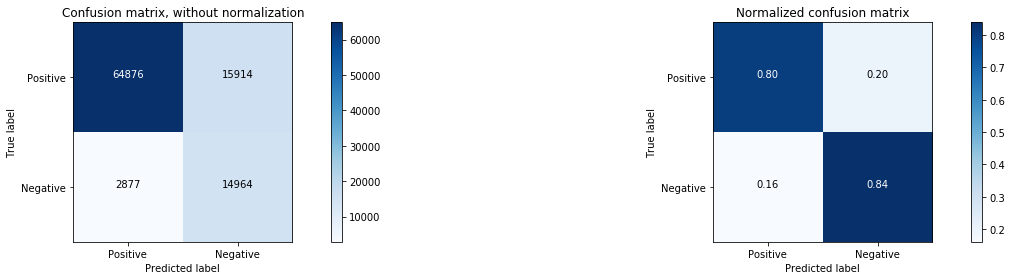

In [63]:
plot_confusion_matrix(gs_l2_tfidfw2v_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 82% which is better than the baseline Naive Bayes Model.
  2. 84% of negative reviews are captured with a poor precision of 48%.
  3. Of the above models, Bag of Words with L2 regularization seems to be good.

### Logistic Regression Model with Average Word2Vec,Random Search CV & L1 regularization

In [64]:
# ========================================== Model with Average W2V features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = tfidf_sent_vect[:train.shape[0]]
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l1'],'alpha': np.random.uniform(10**-2,10**2,10)}
rs_l1_tfidf_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions = param,scoring ='f1',cv = tscv)
rs_l1_tfidf_model.fit(X,Y)

print(rs_l1_tfidf_model.best_estimator_)

SGDClassifier(alpha=99.20696286509038, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


In [67]:
tscv_scores = rs_l1_tfidf_model.cv_results_.get('mean_test_score')
trcv_scores = rs_l1_tfidf_model.cv_results_.get('mean_train_score')

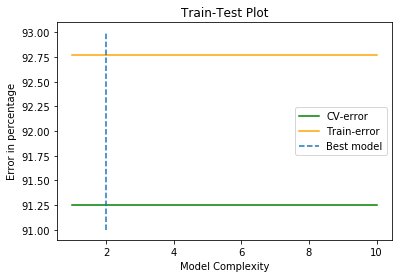

In [70]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9,10]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(2,10),[91,91,91.5,92,93,93,93,93,93,93] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 99.20696286509038. So, picking up the model with alpha = 99.20696286509038

Word2Vec models doesn't have any features, instead it is just a vector representation of features (Sentence/words). Hence, there is no need to check multicollinearity and feature importance in the model.

In [95]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
tscv = TimeSeriesSplit(n_splits= 10)
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(tfidf_sent_vect[:train.shape[0]])
tfidfw2v_tst = X_scaler.transform(sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha =99.20696286509038\
                                , penalty = 'l1')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_l1_tfidfw2v = classifier_name.fit(train_X,train_y)
predtest_y_rs_l1_tfidfw2v = model_rs_l1_tfidfw2v.predict(tfidfw2v_tst)

# Accuracy score
rs_l1_acc_tfidfw2v = accuracy_score(test_y, predtest_y_rs_l1_tfidfw2v, normalize=True)*100
print("Test Accuracy for Logistic Regression model with TFIDF Word2Vec:",rs_l1_acc_tfidfw2v,'%')
# Precision-Recall, f-score
rs_l1_tfidfw2v_pre, rs_l1_tfidfw2v_recall, rs_l1_tfidfw2v_fscore, rs_l1_tfidfw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_l1_tfidfw2v,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",rs_l1_tfidfw2v_pre)
print("Test Recall for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",rs_l1_tfidfw2v_recall)
print("Test fscore for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",rs_l1_tfidfw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_l1_tfidfw2v, pos_label = 1)
rs_l1_tfidfw2v_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with TFIDF Word2Vec:",rs_l1_tfidfw2v_auc_score)
# Confusion matrix
rs_l1_tfidfw2v_cm = confusion_matrix(test_y, predtest_y_rs_l1_tfidfw2v)

Test Accuracy for Logistic Regression model with TFIDF Word2Vec: 81.9113666088755 %
Test Precision for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.0
Test Recall for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.0
Test fscore for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.0
Test AUC for Logistic Regression model with TFIDF Word2Vec: 0.5


In [78]:
# % Zero weight features
(model_rs_l1_avgw2v.coef_==0).sum()/(model_rs_l1_avgw2v.coef_).size

1.0

#### Observation:
  1. Best AUC that we have achieved is 50% which is worse than the baseline Naive Bayes Model, that means the model is a constant model, predicts all as Positive review.
  2. 0% of negative reviews are captured with a precision of 0%.
  3. Of the above models, Bag of Words with L2 regularization (grid search) seems to be good.
  4. All features weights are zero.

### Logistic Regression Model with Average Word2Vec,Random Search CV & L2 regularization

In [66]:
# ========================================== Model with Average W2V features ================================================== 
#10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(n_splits= 10)
X = tfidf_sent_vect[:train.shape[0]]
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'penalty': ['l2'],'alpha': np.random.uniform(10**-2,10**2,10)}
rs_l2_tfidf_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions = param,scoring ='f1',cv = tscv)
rs_l2_tfidf_model.fit(X,Y)

print(rs_l2_tfidf_model.best_estimator_)

SGDClassifier(alpha=14.942782608562267, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=100,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [73]:
tscv_scores = rs_l2_tfidf_model.cv_results_.get('mean_test_score')
trcv_scores = rs_l2_tfidf_model.cv_results_.get('mean_train_score')

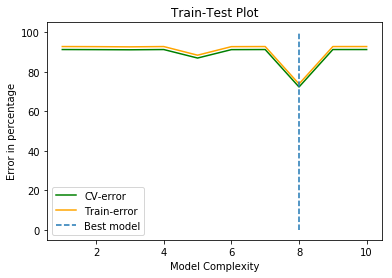

In [76]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9,10]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(8,10),[0,3,5,8,10,12,16,17,88,100] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 14.942782608562267. So, picking up the model with alpha = 14.942782608562267

Word2Vec models doesn't have any features, instead it is just a vector representation of features (Sentence/words). Hence, there is no need to check multicollinearity and feature importance in the model.

In [96]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
tscv = TimeSeriesSplit(n_splits= 10)
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(tfidf_sent_vect[:train.shape[0]])
tfidfw2v_tst = X_scaler.transform(sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'log',class_weight= 'balanced', random_state= 100,alpha = 14.942782608562267\
                                , penalty = 'l2')
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_l2_tfidfw2v = classifier_name.fit(train_X,train_y)
predtest_y_rs_l2_tfidfw2v = model_rs_l2_tfidfw2v.predict(tfidfw2v_tst)

# Accuracy score
rs_l2_acc_tfidfw2v = accuracy_score(test_y, predtest_y_rs_l2_tfidfw2v, normalize=True)*100
print("Test Accuracy for Logistic Regression model with TFIDF Word2Vec:",rs_l2_acc_tfidfw2v,'%')
# Precision-Recall, f-score
rs_l2_tfidfw2v_pre, rs_l2_tfidfw2v_recall, rs_l2_tfidfw2v_fscore, rs_l2_tfidfw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_l2_tfidfw2v,pos_label = 1, average = 'binary')
print("Test Precision for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",rs_l2_tfidfw2v_pre)
print("Test Recall for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",rs_l2_tfidfw2v_recall)
print("Test fscore for Logistic Regression model with TFIDF Word2Vec for Negative label reviews:",rs_l2_tfidfw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_l2_tfidfw2v, pos_label = 1)
rs_l2_tfidfw2v_auc_score = auc(fpr,tpr)
print("Test AUC for Logistic Regression model with TFIDF Word2Vec:",rs_l2_tfidfw2v_auc_score)
# Confusion matrix
rs_l2_tfidfw2v_cm = confusion_matrix(test_y, predtest_y_rs_l2_tfidfw2v)

Test Accuracy for Logistic Regression model with TFIDF Word2Vec: 82.88367754559926 %
Test Precision for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.8457101658255227
Test Recall for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.0657474356818564
Test fscore for Logistic Regression model with TFIDF Word2Vec for Negative label reviews: 0.12200956937799043
Test AUC for Logistic Regression model with TFIDF Word2Vec: 0.5315492965016535


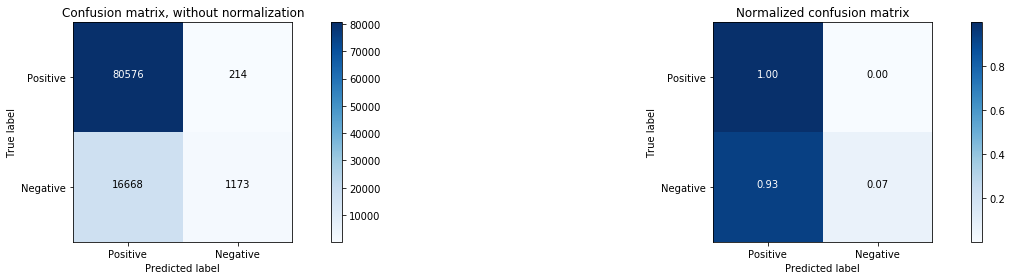

In [72]:
plot_confusion_matrix(rs_l2_tfidfw2v_cm, ['Positive','Negative'])

#### Observation:
  1. Best AUC that we have achieved is 53% which is worse than the baseline Naive Bayes Model.
  2. 6.5% of negative reviews are captured with a very good precision of 85%.
  3. Of the above models, Bag of Words with L2 regularization seems to be good.

## ============================== Conclusion: ================================

In [100]:
table = [["Bag Of Words", "Grid Search", "L2-Ridge Regression",gs_l2_acc_bow, gs_l2_bow_pre,\
          gs_l2_bow_recall, gs_l2_bow_fscore,gs_l2_bow_auc_score],
         ["TF-IDF", "Grid Search", "L2- Ridge Regression",gs_l2_acc_tfidf, gs_l2_tfidf_pre,\
          gs_l2_tfidf_recall,gs_l2_tfidf_fscore,gs_l2_tfidf_auc_score],
         ["Average Word2Vec", "Grid Search", "L2- Ridge Regression",gs_l2_acc_avgw2v, gs_l2_avgw2v_pre,\
          gs_l2_avgw2v_recall,gs_l2_avgw2v_fscore,gs_l2_avgw2v_auc_score],
         ["TF-IDF Word2Vec", "Grid Search","L2-Ridge Regression", gs_l2_acc_tfidfw2v, gs_l2_tfidfw2v_pre,\
          gs_l2_tfidfw2v_recall,gs_l2_tfidfw2v_fscore,gs_l2_tfidfw2v_auc_score],
         ["Bag Of Words", "Grid Search", "L1-Lasso Regression",gs_l1_acc_bow, gs_l1_bow_pre,\
          gs_l1_bow_recall, gs_l1_bow_fscore,gs_l1_bow_auc_score],
         ["TF-IDF", "Grid Search",  "L1-Lasso Regression",gs_l1_acc_tfidf, gs_l1_tfidf_pre,\
          gs_l1_tfidf_recall,gs_l1_tfidf_fscore,gs_l1_tfidf_auc_score],
         ["Average Word2Vec", "Grid Search",  "L1-Lasso Regression",gs_l1_acc_avgw2v, gs_l1_avgw2v_pre,\
          gs_l1_avgw2v_recall,gs_l1_avgw2v_fscore,gs_l1_avgw2v_auc_score],
         ["TF-IDF Word2Vec", "Grid Search", "L1-Lasso Regression", gs_l1_acc_tfidfw2v, gs_l1_tfidfw2v_pre,\
          gs_l1_tfidfw2v_recall,gs_l1_tfidfw2v_fscore,gs_l1_tfidfw2v_auc_score]
        ]
pd.DataFrame(table, columns = ["Model","Search Method","Regularization","Accuracy", "Precision", "Recall","f-score","AUC"])

,Model,Search Method,Regularization,Accuracy,Precision,Recall,f-score,AUC
0,Bag Of Words,Grid Search,L2-Ridge Regression,87.778690,0.618281,0.847766,0.715062,0.866091
1,TF-IDF,Grid Search,L2- Ridge Regression,84.376109,0.543233,0.856062,0.664679,0.848553
2,Average Word2Vec,Grid Search,L2- Ridge Regression,82.887733,0.516004,0.870187,0.647847,0.844971
3,TF-IDF Word2Vec,Grid Search,L2-Ridge Regression,80.948181,0.484617,0.838742,0.614298,0.820881
4,Bag Of Words,Grid Search,L1-Lasso Regression,84.289929,0.545910,0.781795,0.642898,0.819094
5,TF-IDF,Grid Search,L1-Lasso Regression,74.086241,0.377094,0.663640,0.480920,0.710778
6,Average Word2Vec,Grid Search,L1-Lasso Regression,82.638319,0.511819,0.870187,0.644539,0.843448
7,TF-IDF Word2Vec,Grid Search,L1-Lasso Regression,80.925875,0.484247,0.837397,0.613641,0.820221


In [103]:
table = [["Bag Of Words", "Grid Search", "L2-Ridge Regression",rs_l2_acc_bow, rs_l2_bow_pre,\
          rs_l2_bow_recall, rs_l2_bow_fscore,rs_l2_bow_auc_score],
         ["TF-IDF", "Grid Search", "L2- Ridge Regression",rs_l2_acc_tfidf, rs_l2_tfidf_pre,\
          rs_l2_tfidf_recall,rs_l2_tfidf_fscore,rs_l2_tfidf_auc_score],
         ["Average Word2Vec", "Grid Search", "L2- Ridge Regression",rs_l2_acc_avgw2v, rs_l2_avgw2v_pre,\
          rs_l2_avgw2v_recall,rs_l2_avgw2v_fscore,rs_l2_avgw2v_auc_score],
         ["TF-IDF Word2Vec", "Grid Search","L2-Ridge Regression", rs_l2_acc_tfidfw2v, rs_l2_tfidfw2v_pre,\
          rs_l2_tfidfw2v_recall,rs_l2_tfidfw2v_fscore,rs_l2_tfidfw2v_auc_score],
         ["Bag Of Words", "Grid Search", "L1-Lasso Regression",rs_l1_acc_bow, rs_l1_bow_pre,\
          rs_l1_bow_recall, rs_l1_bow_fscore,rs_l1_bow_auc_score],
         ["TF-IDF", "Grid Search",  "L1-Lasso Regression",rs_l1_acc_tfidf, gs_l1_tfidf_pre,\
          rs_l1_tfidf_recall,rs_l1_tfidf_fscore,rs_l1_tfidf_auc_score],
         ["Average Word2Vec", "Grid Search",  "L1-Lasso Regression",rs_l1_acc_avgw2v, rs_l1_avgw2v_pre,\
          rs_l1_avgw2v_recall,rs_l1_avgw2v_fscore,rs_l1_avgw2v_auc_score],
         ["TF-IDF Word2Vec", "Grid Search", "L1-Lasso Regression", rs_l1_acc_tfidfw2v, rs_l1_tfidfw2v_pre,\
          rs_l1_tfidfw2v_recall,rs_l1_tfidfw2v_fscore,rs_l1_tfidfw2v_auc_score]
        ]
pd.DataFrame(table, columns = ["Model","Search Method","Regularization","Accuracy", "Precision", "Recall","f-score","AUC"])

,Model,Search Method,Regularization,Accuracy,Precision,Recall,f-score,AUC
0,Bag Of Words,Grid Search,L2-Ridge Regression,87.400513,0.608219,0.852755,0.710022,0.865726
1,TF-IDF,Grid Search,L2- Ridge Regression,87.860815,0.632616,0.784485,0.700413,0.841939
2,Average Word2Vec,Grid Search,L2- Ridge Regression,81.599092,0.494732,0.810661,0.614466,0.813914
3,TF-IDF Word2Vec,Grid Search,L2-Ridge Regression,82.883678,0.845710,0.065747,0.122010,0.531549
4,Bag Of Words,Grid Search,L1-Lasso Regression,81.910353,0.000000,0.000000,0.000000,0.499994
5,TF-IDF,Grid Search,L1-Lasso Regression,81.911367,0.377094,0.000000,0.000000,0.500000
6,Average Word2Vec,Grid Search,L1-Lasso Regression,81.911367,0.000000,0.000000,0.000000,0.500000
7,TF-IDF Word2Vec,Grid Search,L1-Lasso Regression,81.911367,0.000000,0.000000,0.000000,0.500000


Logistic Regression is best and powerful model in terms of simplicity and interpretability. As we can see, we have achieved better metric (AUC as well f1score) compared to Naive Bayes Model. There is very less impact of outliers on Logistic Regression. Standardization and Sigmoid function has dampened the effect of outliers in the model. 

From the above tables, we can see that Bag of Words Featurization with L2 Regularization, paramater found with Grid Search is the best model with f1 score of 71% and AUC of 87%, though these metrices are good, the precision level of model with reference to Negative Review is low, compared to the test precision of 85% achieved with Naive Bayes Model.